In [187]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from math import ceil
from joblib import Parallel, delayed
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from __future__ import annotations
from typing import Dict, List, Tuple, Optional, Set
import networkx as nx

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (10, 6),
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "lines.linewidth": 2,
    }
)

In [3]:
%matplotlib inline

### Gillespie's Algorithm

In [ ]:
def sir_rhs(t, y, beta, gamma, mu, N):
    """
    Frequency-dependent SIR with births/deaths.

    Parameters:
        beta: transmission rate
        gamma: recovery rate
        mu: birth/death rate
        N: total population size

    Returns:
        [dX/dt, dY/dt, dZ/dt] where X=susceptible, Y=infected, Z=recovered (counts)
    """
    X, Y, Z = y
    dX = mu * N - beta * X * Y / N - mu * X
    dY = beta * X * Y / N - gamma * Y - mu * Y
    dZ = gamma * Y - mu * Z
    return [dX, dY, dZ]


def integrate_sir(beta, gamma, mu, N, X0, Y0, Z0, t_span=(0.0, 160.0), num_points=1000):
    """Deterministic ODE solution for SIR model."""
    y0 = [float(X0), float(Y0), float(Z0)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    sol = solve_ivp(
        lambda t, y: sir_rhs(t, y, beta, gamma, mu, N),
        t_span,
        y0,
        t_eval=t_eval,
        method="RK45",
        rtol=1e-8,
        atol=1e-10,
    )

    Y = np.clip(sol.y, 0.0, None)
    return {"t": sol.t, "X": Y[0], "Y": Y[1], "Z": Y[2]}


def gillespie_sir(beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=None):
    """
    Stochastic Gillespie simulation of SIR with vital dynamics.

    Events:
        Infection: X→Y, rate = beta*X*Y/N
        Recovery: Y→Z, rate = gamma*Y
        Birth: X+1, rate = mu*N
        Death (X,Y,Z): rate = mu*(X,Y,Z)
    """
    if rng is None:
        rng = np.random.default_rng()

    X, Y, Z = int(X0), int(Y0), int(Z0)
    t = 0.0
    times = [0.0]
    X_hist, Y_hist, Z_hist = [X], [Y], [Z]

    while t < tmax and Y > 0:
        # Rates
        rate_I = beta * X * Y / N
        rate_R = gamma * Y
        rate_B = mu * N
        rate_DX = mu * X
        rate_DY = mu * Y
        rate_DZ = mu * Z
        total_rate = rate_I + rate_R + rate_B + rate_DX + rate_DY + rate_DZ

        # Waiting time
        t += -np.log(rng.random()) / total_rate

        # Select event
        r = rng.random() * total_rate
        if r < rate_I and X > 0:
            X -= 1
            Y += 1
        elif r < rate_I + rate_R and Y > 0:
            Y -= 1
            Z += 1
        elif r < rate_I + rate_R + rate_B:
            X += 1
            N += 1
        elif r < rate_I + rate_R + rate_B + rate_DX and X > 0:
            X -= 1
            N -= 1
        elif r < rate_I + rate_R + rate_B + rate_DX + rate_DY and Y > 0:
            Y -= 1
            N -= 1
        elif Z > 0:
            Z -= 1
            N -= 1

        times.append(t)
        X_hist.append(X)
        Y_hist.append(Y)
        Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)


def resample_step(times, values, t_grid):
    """Resample event-driven trajectory onto regular time grid."""
    out = np.empty_like(t_grid, dtype=float)
    j = 0
    curr = values[0]
    for k, tk in enumerate(t_grid):
        while j + 1 < len(times) and times[j + 1] <= tk:
            j += 1
            curr = values[j]
        out[k] = curr
    return out


def run_ensemble(
    beta,
    gamma,
    mu,
    N,
    X0,
    Y0,
    Z0,
    t_span=(0.0, 160.0),
    num_points=1000,
    n_runs=200,
    seed0=12345,
):
    """
    Run ensemble of stochastic simulations w/ deterministic solution.

    Returns:
        t_grid, det (dict with X,Y,Z), X_paths, Y_paths, Z_paths (n_runs x num_points)
    """

    # Det solution
    det = integrate_sir(beta, gamma, mu, N, X0, Y0, Z0, t_span, num_points)
    t_grid = det["t"]

    # Stochastic ensemble
    X_paths = np.zeros((n_runs, num_points))
    Y_paths = np.zeros((n_runs, num_points))
    Z_paths = np.zeros((n_runs, num_points))

    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, t_span[1], rng
        )
        X_paths[r, :] = resample_step(times, X_hist, t_grid)
        Y_paths[r, :] = resample_step(times, Y_hist, t_grid)
        Z_paths[r, :] = resample_step(times, Z_hist, t_grid)

    return t_grid, det, X_paths, Y_paths, Z_paths

### Variance and Negative Covariance

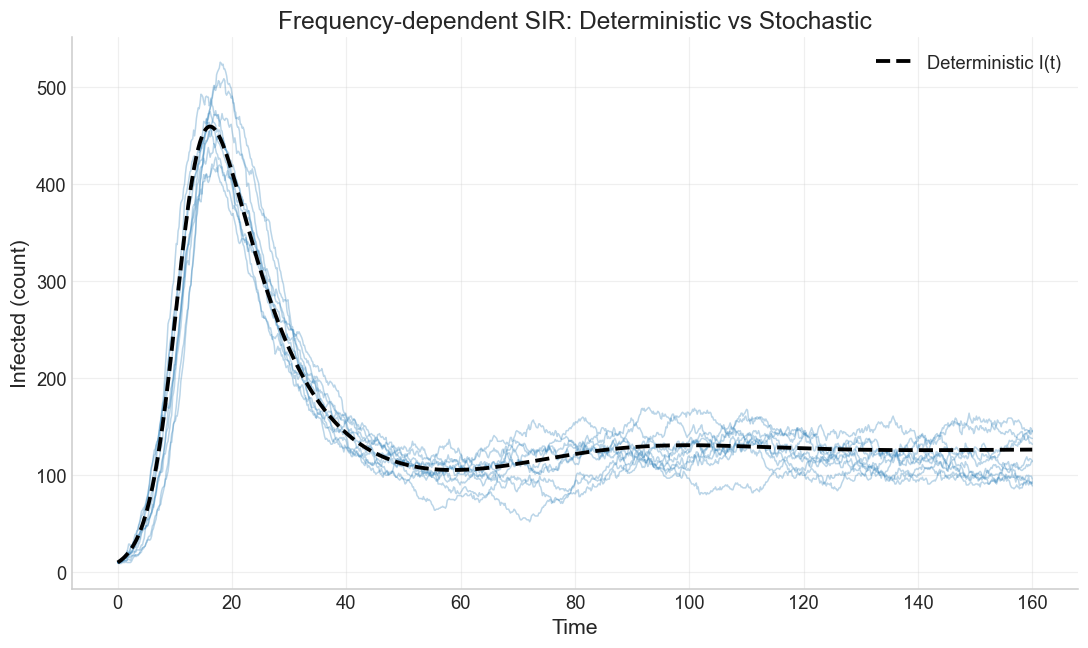

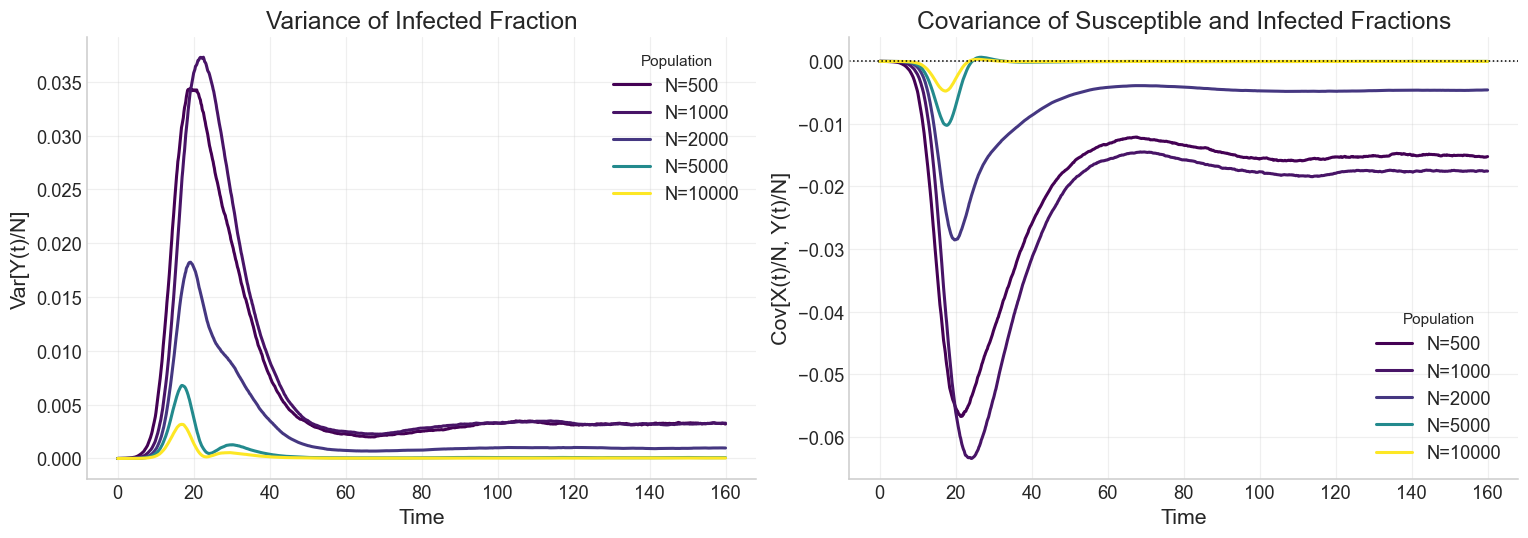

In [130]:
# Parameters
beta = 0.5
gamma = 0.1
mu = 1 / 50
N = 1000
I0 = 10
S0 = N - I0
R0 = 0
t_span = (0.0, 160.0)

# Run ensemble
t_grid, det, X_paths, Y_paths, Z_paths = run_ensemble(
    beta, gamma, mu, N, S0, I0, R0, t_span=t_span, n_runs=200, seed0=12345
)

# Plot trajectories vs deterministic
fig, ax = plt.subplots(figsize=(10, 6))
n_show = 10
for r in range(n_show):
    ax.plot(t_grid, Y_paths[r, :], color="tab:blue", alpha=0.3, lw=1)
ax.plot(det["t"], det["Y"], "k--", lw=2.5, label="Deterministic I(t)")
ax.set_xlabel("Time")
ax.set_ylabel("Infected (count)")
ax.set_title("Frequency-dependent SIR: Deterministic vs Stochastic")
ax.legend()
plt.tight_layout()
plt.show()


#####################################################################
# Population Size Scaling
##########################################################################

# Fixed parameters
N_list = [500, 1000, 2000, 5000, 10000]
I0_fixed = 5
i0_frac = I0_fixed / 5000

fig, (ax_var, ax_cov) = plt.subplots(1, 2, figsize=(14, 5))
Nmin, Nmax = min(N_list), max(N_list)

for N in N_list:
    # Scale initial infected
    Y0 = max(1, int(ceil(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    # Run ensemble
    t, det, X_paths, Y_paths, Z_paths = run_ensemble(
        beta,
        gamma,
        mu,
        N,
        X0,
        Y0,
        Z0,
        t_span=t_span,
        num_points=1000,
        n_runs=200,
        seed0=6000,
    )

    # Convert to fractions and compute statistics
    y_paths = Y_paths / N
    x_paths = X_paths / N
    y_var = y_paths.var(axis=0, ddof=1)
    xy_cov = (x_paths * y_paths).mean(axis=0) - x_paths.mean(axis=0) * y_paths.mean(
        axis=0
    )

    color = plt.cm.viridis((N - Nmin) / (Nmax - Nmin))
    ax_var.plot(t, y_var, color=color, label=f"N={N}")
    ax_cov.plot(t, xy_cov, color=color, label=f"N={N}")

ax_cov.axhline(0, color="k", lw=1, ls=":")
ax_var.set_title("Variance of Infected Fraction")
ax_var.set_xlabel("Time")
ax_var.set_ylabel("Var[Y(t)/N]")
ax_var.legend(title="Population")

ax_cov.set_title("Covariance of Susceptible and Infected Fractions")
ax_cov.set_xlabel("Time")
ax_cov.set_ylabel("Cov[X(t)/N, Y(t)/N]")
ax_cov.legend(title="Population")

plt.tight_layout()
plt.show()

### $\tau$-Leap Implementation

***Note***: This section presents our implementation of the noise reduction bonus part of the assignment

In [188]:
def tau_leap_sir(beta, gamma, mu, N, X0, Y0, Z0, tmax, tau, rng=None):
    """
    Tau-leap approximation for SIR with demography.

    Parameters:
        beta: transmission rate
        gamma: recovery rate
        mu: birth/death rate
        N: total population size
        X0, Y0, Z0: initial counts of S, I, R
        tmax: maximum simulation time
        tau: time step for tau-leap
        rng: random number generator (optional)
    Returns:
        times, X_hist, Y_hist, Z_hist (arrays of times and counts)
    """
    if rng is None:
        rng = np.random.default_rng()

    X, Y, Z = int(X0), int(Y0), int(Z0)
    t = 0.0
    times = [0.0]
    X_hist, Y_hist, Z_hist = [X], [Y], [Z]

    while t < tmax and Y > 0:
        # Rates
        rate_I = beta * X * Y / N
        rate_R = gamma * Y
        rate_B = mu * N
        rate_DX = mu * X
        rate_DY = mu * Y
        rate_DZ = mu * Z

        # Number of events in time tau
        n_I = rng.poisson(rate_I * tau) if X > 0 else 0
        n_R = rng.poisson(rate_R * tau) if Y > 0 else 0
        n_B = rng.poisson(rate_B * tau)
        n_DX = rng.poisson(rate_DX * tau) if X > 0 else 0
        n_DY = rng.poisson(rate_DY * tau) if Y > 0 else 0
        n_DZ = rng.poisson(rate_DZ * tau) if Z > 0 else 0

        # Update counts
        X += n_B - n_I - n_DX
        Y += n_I - n_R - n_DY
        Z += n_R - n_DZ
        N += n_B - n_DX - n_DY - n_DZ

        # Ensure counts are non-negative
        X = max(X, 0)
        Y = max(Y, 0)
        Z = max(Z, 0)
        N = max(N, 0)

        t += tau
        times.append(t)
        X_hist.append(X)
        Y_hist.append(Y)
        Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)


def compare_tau_methods(
    beta=0.5,
    gamma=0.1,
    mu=1 / 50,
    N=1000,
    X0=990,
    Y0=10,
    Z0=0,
    tmax=50,
    n_runs=50,
    seed0=42,
):
    """
    Simple experiment comparing standard deviation across SIR methods.

    Returns:
        Dict with method names as keys and standard deviations as values
    """
    
    t_grid = np.linspace(0, tmax, 500)

    det_solution = integrate_sir(
        beta, gamma, mu, N, X0, Y0, Z0, t_span=(0.0, tmax), num_points=500
    )

    gillespie_trajectories = []
    for run in range(n_runs):
        rng = np.random.default_rng(seed0 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=rng
        )
        Y_uniform = resample_step(times, Y_hist, t_grid)
        gillespie_trajectories.append(Y_uniform)

    gillespie_array = np.array(gillespie_trajectories)
    gillespie_std = np.mean(gillespie_array.std(axis=0))

    # tau-leap sweep
    tau_values = [0.001, 0.01, 0.1]
    tau_results = {}

    for tau in tau_values:
        tau_trajectories = []

        for run in range(n_runs):
            rng = np.random.default_rng(seed0 + run + int(tau * 10000))
            times_tau, X_tau, Y_tau, Z_tau = tau_leap_sir(
                beta, gamma, mu, N, X0, Y0, Z0, tmax, tau, rng=rng
            )
            Y_tau_uniform = resample_step(times_tau, Y_tau, t_grid)
            tau_trajectories.append(Y_tau_uniform)

        tau_array = np.array(tau_trajectories)
        tau_std = np.mean(tau_array.std(axis=0))
        tau_results[tau] = tau_std

    results = {
        "deterministic": 0.0,
        "gillespie": gillespie_std,
        **{f"tau_leap_{tau}": std_val for tau, std_val in tau_results.items()},
    }

    return results

In [ ]:
results = compare_tau_methods(
    beta=0.5,
    gamma=0.1,
    mu=1 / 50,
    N=1000,
    X0=990,
    Y0=10,
    Z0=0,
    tmax=50,
    n_runs=100,
    seed0=42,
)

# Display results
print(f"{'Method':<20} {'Standard Deviation':<20}\n")

sorted_results = sorted(results.items(), key=lambda x: x[1])
for method, std_dev in sorted_results:
    if method == "deterministic":
        print(f"{'Deterministic':<20} {std_dev:<20.2f}")
    elif method == "gillespie":
        print(f"{'Gillespie':<20} {std_dev:<20.2f}")
    else:
        tau_val = method.replace("tau_leap_", "")
        print(f"{'Tau-leap τ='+tau_val:<20} {std_dev:<20.2f}")

### Trasient Behavior

In [13]:
def find_sir_equilibrium(beta, gamma, mu, N):
    """Find the endemic equilibrium for SIR with demography"""
    R0 = beta / (gamma + mu)
    if R0 <= 1.0:
        return (N, 0, 0)
    else:
        X_eq = N / R0
        Y_eq = mu * N * (R0 - 1) / beta
        Z_eq = N - X_eq - Y_eq
        return (X_eq, Y_eq, Z_eq)

In [131]:
def compute_psd(y_signal, dt):
    """
    Compute power spectral density using FFT.
    Returns:
        freqs: frequency bins
        psd: power spectral density values
    """

    # SS-half
    mid = len(y_signal) // 2
    y_steady = y_signal[mid:]

    # Detrend (mean) and window
    y_centered = y_steady - np.mean(y_steady)
    window = np.hanning(len(y_centered))
    y_windowed = y_centered * window

    # FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(len(y_windowed), d=dt)

    Fs = 1.0 / dt
    psd = (np.abs(fft_vals) ** 2) / (Fs * np.sum(window**2))

    if len(psd) > 2:
        psd[1:-1] *= 2

    return freqs, psd

In [132]:
def analyze_resonance(beta, gamma, mu, N, n_runs=30, tmax=400):
    """
    Analyze stochastic resonance by running simulations and computing averaged PSD.

    Returns:
        Dict with keys:
            'freqs': frequency bins
            'avg_psd': averaged power spectral density
            'peak_freq': frequency of peak (or None)
            'peak_power': power at peak (or None)
            'trajectories': list of Y(t) trajectories
            't_grid': time grid used
            'Y_eq': equilibrium infected count
    """
    # Time grid for resampling
    t_grid = np.linspace(0, tmax, 4000)
    dt = t_grid[1] - t_grid[0]
    X_eq, Y_eq, Z_eq = find_sir_equilibrium(beta, gamma, mu, N)
    X0, Y0, Z0 = int(X_eq), max(1, int(Y_eq)), int(Z_eq)

    all_psds = []
    all_trajectories = []

    # Run simulations
    for run in range(n_runs):
        rng = np.random.default_rng(1000 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=rng
        )
        Y_uniform = resample_step(times, Y_hist, t_grid)
        all_trajectories.append(Y_uniform)

        freqs, psd = compute_psd(Y_uniform / N, dt)
        all_psds.append(psd)

    # Average PSD
    avg_psd = np.mean(all_psds, axis=0)

    # Find peak frequency
    f_nyq = 0.5 / dt
    f_low = 1.0 / tmax
    f_high = min(0.1, 0.9 * f_nyq)
    mask = (freqs >= f_low) & (freqs <= f_high)

    peak_freq = None
    peak_power = None
    if np.any(mask):
        prom = np.percentile(avg_psd[mask], 85)
        peaks, properties = find_peaks(
            avg_psd[mask], prominence=max(1e-12, prom), width=1
        )
        if len(peaks) > 0:
            masked_psd = avg_psd[mask]
            best = peaks[np.argmax(masked_psd[peaks])]
            peak_freq = freqs[mask][best]
            peak_power = masked_psd[best]

    return {
        "freqs": freqs,
        "avg_psd": avg_psd,
        "peak_freq": peak_freq,
        "peak_power": peak_power,
        "trajectories": all_trajectories,
        "t_grid": t_grid,
        "Y_eq": Y_eq,
    }

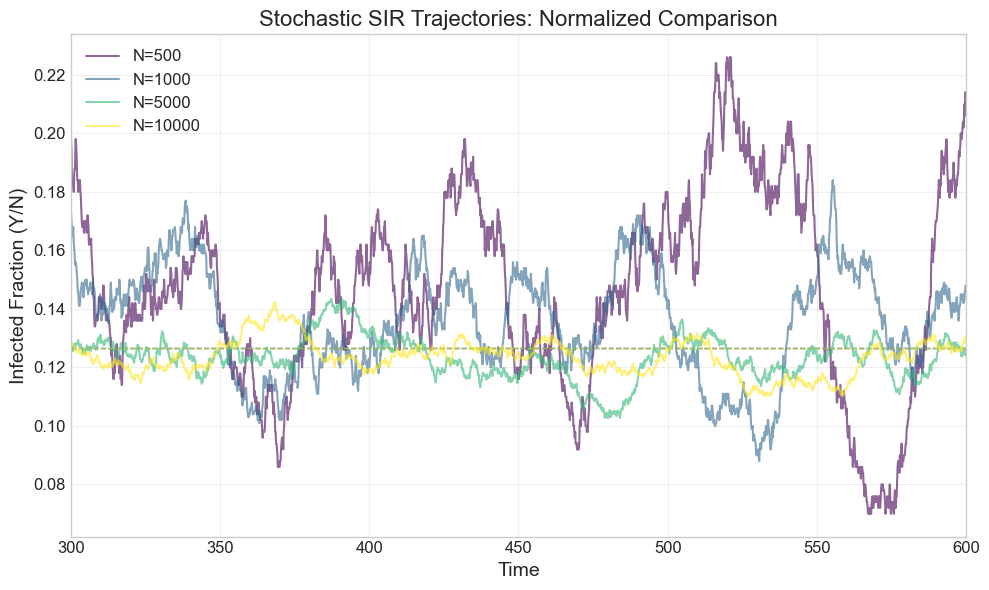

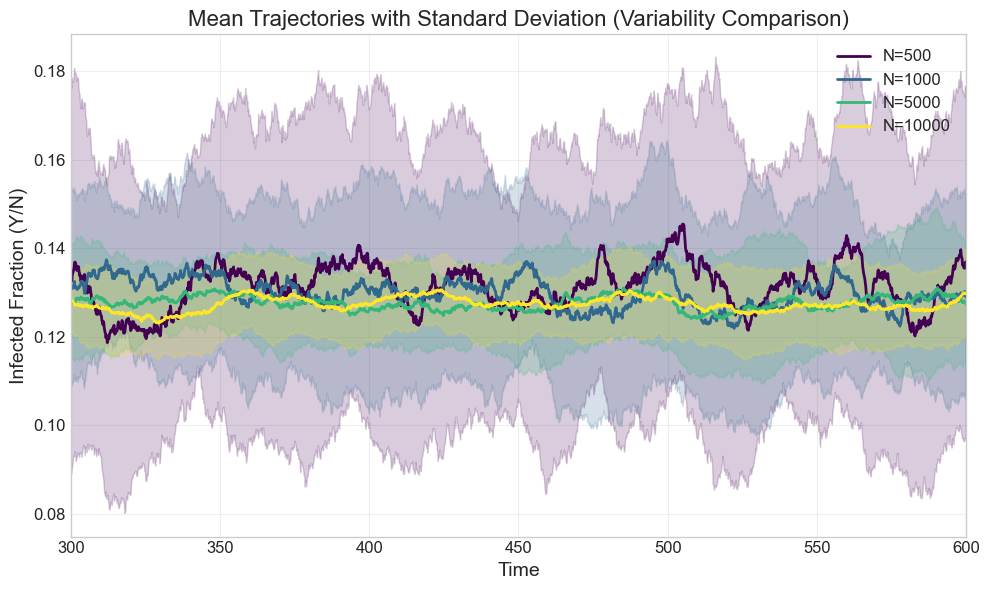

In [17]:
# Params (as always so far)
gamma = 0.1
beta = 0.5
mu = 1 / 50
N_values = [500, 1000, 5000, 10000]

# Run resonance analysis
resonance_results = []
for N in N_values:
    res = analyze_resonance(beta, gamma, mu, N, n_runs=20, tmax=600)
    resonance_results.append(res)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(N_values)))

for N, res, color in zip(N_values, resonance_results, colors):
    # Convert all trajectories to fractions
    y_frac = res["trajectories"][0] / N
    y_eq_frac = res["Y_eq"] / N
    ax.plot(res["t_grid"], y_frac, alpha=0.6, lw=1.5, color=color, label=f"N={N}")
    ax.axhline(y_eq_frac, ls="--", lw=1.0, alpha=0.5, color=color)

ax.set_xlabel("Time")
ax.set_ylabel("Infected Fraction (Y/N)")
ax.set_title("Stochastic SIR Trajectories: Normalized Comparison")
ax.set_xlim([300, 600])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  Variability: mean +- std envelope
fig, ax = plt.subplots(figsize=(10, 6))

for N, res, color in zip(N_values, resonance_results, colors):
    traj_array = np.array(res["trajectories"]) / N
    mean_traj = traj_array.mean(axis=0)
    std_traj = traj_array.std(axis=0)

    ax.plot(res["t_grid"], mean_traj, lw=2, color=color, label=f"N={N}")
    ax.fill_between(
        res["t_grid"],
        mean_traj - std_traj,
        mean_traj + std_traj,
        alpha=0.2,
        color=color,
    )

ax.set_xlabel("Time")
ax.set_ylabel("Infected Fraction (Y/N)")
ax.set_title("Mean Trajectories with Standard Deviation (Variability Comparison)")
ax.set_xlim([300, 600])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [134]:
def analyze_transients_around_eq(
    beta, gamma, mu, N, n_runs=40, tmax=800, num_points=2000, burn_frac=0.5, seed0=2000
):
    """
    Measure mean peak overshoot in stationary window

    Returns:
        Mean overshoot (float) or NaN if no endemic equilibrium
    """
    eq = find_sir_equilibrium(beta, gamma, mu, N)
    if eq is None:
        return np.nan

    X_star, Y_star, Z_star = eq
    X0 = max(0, int(round(X_star)))
    Y0 = max(1, int(round(Y_star)))
    Z0 = max(0, int(round(Z_star)))

    t_grid = np.linspace(0.0, tmax, num_points)
    burn = int(burn_frac * num_points)

    overs = []
    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )
        Y_uni = resample_step(times, Y_hist, t_grid)
        peak_ss = float(np.max(Y_uni[burn:]))
        os = max(0.0, (peak_ss - Y_star) / N)
        overs.append(os)

    return float(np.mean(overs))

In [135]:
def sweep_mean_overshoot(
    N_grid,
    R0_grid,
    gamma,
    mu,
    n_runs=40,
    tmax=800,
    num_points=2000,
    burn_frac=0.5,
    n_jobs=-1,
):
    """
    Sweep over (N, R0) grid to compute mean overshoot.
    Returns:
        2D array of mean overshoot values with shape (len(N_grid), len(R0_grid))
    """
    params = [(N, R0) for N in N_grid for R0 in R0_grid]

    #
    def run_point(N, R0):
        if R0 <= 1.0:
            return np.nan
        beta = R0 * (gamma + mu)
        return analyze_transients_around_eq(
            beta,
            gamma,
            mu,
            N,
            n_runs=n_runs,
            tmax=tmax,
            num_points=num_points,
            burn_frac=burn_frac,
        )

    vals = Parallel(n_jobs=n_jobs, verbose=10, prefer="processes")(
        delayed(run_point)(N, R0) for (N, R0) in params
    )

    M, B = len(N_grid), len(R0_grid)
    return np.array(vals).reshape(M, B)

***Note***: This is a very expensive computation. The function is implemented in parallel with n_jobs = -1 to use all workers! 

In [ ]:
gamma, mu = 0.1, 1 / (50 * 365)
N_grid = np.linspace(200, 3000, 10, dtype=int)
R0_grid = np.linspace(1.5, 10, 10)

mean_os = sweep_mean_overshoot(
    N_grid,
    R0_grid,
    gamma,
    mu,
    n_runs=40,
    tmax=800,
    num_points=2000,
    burn_frac=0.5,
    n_jobs=-1,
)

fig, ax = plt.subplots(figsize=(7.5, 5.5), constrained_layout=True)

im = ax.imshow(
    mean_os,
    origin="lower",
    aspect="auto",
    extent=[R0_grid[0], R0_grid[-1], N_grid[0], N_grid[-1]],
    cmap="viridis",
)
ax.set_title("Mean peak overshoot (stationary window)")
ax.set_xlabel(r"$R_0$")
ax.set_ylabel("Population size $N$")
c = plt.colorbar(im, ax=ax)
c.set_label("Overshoot ratio")

### Extinction Events

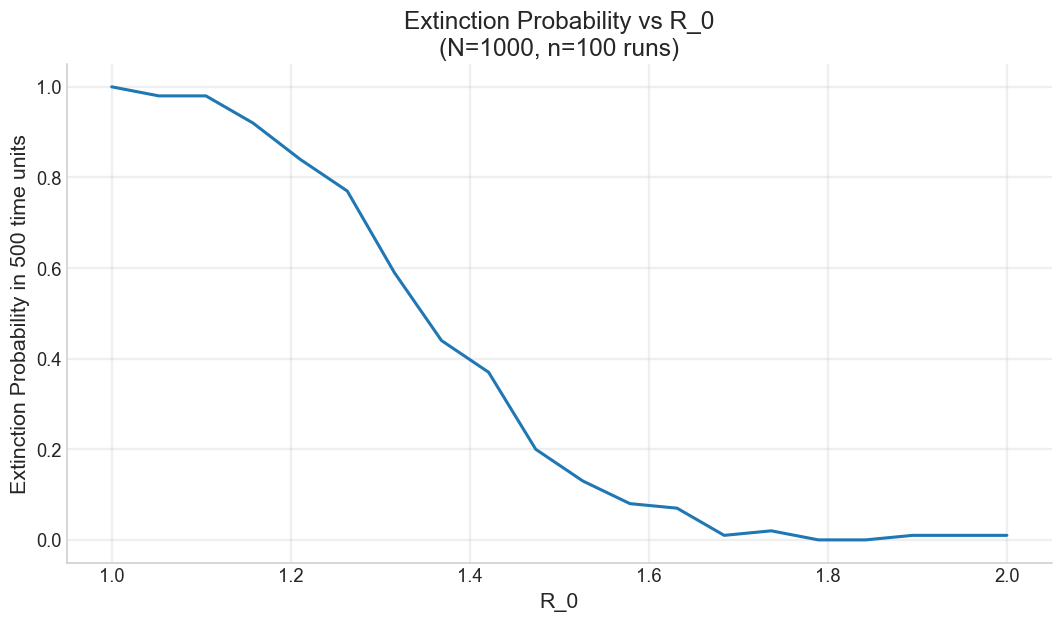

In [448]:
# Params

R0 = np.linspace(1, 2, 20)
gamma = 0.1
mu = 1 / 50
beta = [R0_i * (gamma + mu) for R0_i in R0]
N = 1000
X0 = np.round(0.05 * N)
Y0 = N - X0
Z0 = 0
seed0 = 42

n_runs = 100  #
tmax = 500.0  # Max simualtion time

mean_extinction_counts = []
mean_extinction_times = []


for idx, (R0_val, beta_val) in enumerate(zip(R0, beta)):
    extinctions = []
    extinction_times = []

    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )

        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else:
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(R0, mean_extinction_counts, linewidth=2)
ax.set_xlabel("R_0")
ax.set_ylabel("Extinction Probability in 500 time units")
ax.set_title(f"Extinction Probability vs R_0\n(N={N}, n={n_runs} runs)")
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [ ]:
# Params
R0 = 1.3
gamma = 0.1
mu = 1 / 50
beta = R0 * (gamma + mu)
N = np.linspace(500, 6000, 20, dtype=int)
X0 = 50
Y0 = [N_val - X0 for N_val in N]
Z0 = 0
seed0 = 42
n_runs = 100
tmax = 500.0

mean_extinction_counts = []
mean_extinction_times = []


for idx, (N_val, Y0_val) in enumerate(zip(N, Y0)):
    extinctions = []
    extinction_times = []

    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N_val, X0, Y0_val, Z0, tmax=tmax, rng=rng
        )
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else:
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(N, mean_extinction_counts, linewidth=2)
ax.set_xlabel("N")
ax.set_ylabel("Extinction Probability")
ax.set_title(f"Extinction Probability vs N\n(R_0={R0}, n={n_runs} runs)")
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

***Note***: Once again, this is a very expensive computation with an approximate completion time of ~25 minutes

In [189]:
def run_parameter_combination(
    R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed
):
    """
    Run simulations for a single (R0, N) parameter combination.
    Returns extinction probability for that combination.

    Returns:
        extinction_prob: float
    """
    extinctions = []
    Y0_val = N_val - X0
    Z0_val = 0

    for run in range(n_runs):
        seed = base_seed + run * 10000
        rng = np.random.default_rng(seed=seed)

        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N_val, X0, Y0_val, Z0_val, tmax=tmax, rng=rng
        )
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else:
            extinctions.append(0)

    return np.mean(extinctions)

In [ ]:
gamma = 0.1
mu = 1 / 50
seed0 = 42

# Define parameter ranges
N_values = np.linspace(500, 5000, 10, dtype=int)  # Population sizes
R0_values = np.linspace(1, 2, 10)  # R0 values
beta_values = [R0_val * (gamma + mu) for R0_val in R0_values]

# Fixed parameters
X0 = 50  # Initial infected
tmax = 500.0  # Maximum simulation time
n_runs = 50  # Runs per parameter combination

# Prepare parameter combinations for joblib
param_combinations = []
combo_id = 0

for i, R0_val in enumerate(R0_values):
    beta_val = beta_values[i]
    for j, N_val in enumerate(N_values):
        # Create unique base seed for each parameter combination
        base_seed = seed0 + combo_id * 1000

        param_combinations.append(
            (i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed)
        )
        combo_id += 1

# Run multiprocessing with joblib

# Use joblib with all available cores and progress tracking
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_parameter_combination)(
        R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed
    )
    for i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed in param_combinations
)

# Reconstruct heatmap from results
extinction_heatmap = np.zeros((len(R0_values), len(N_values)))

for (i, j, *_), result in zip(param_combinations, results):
    extinction_heatmap[i, j] = result

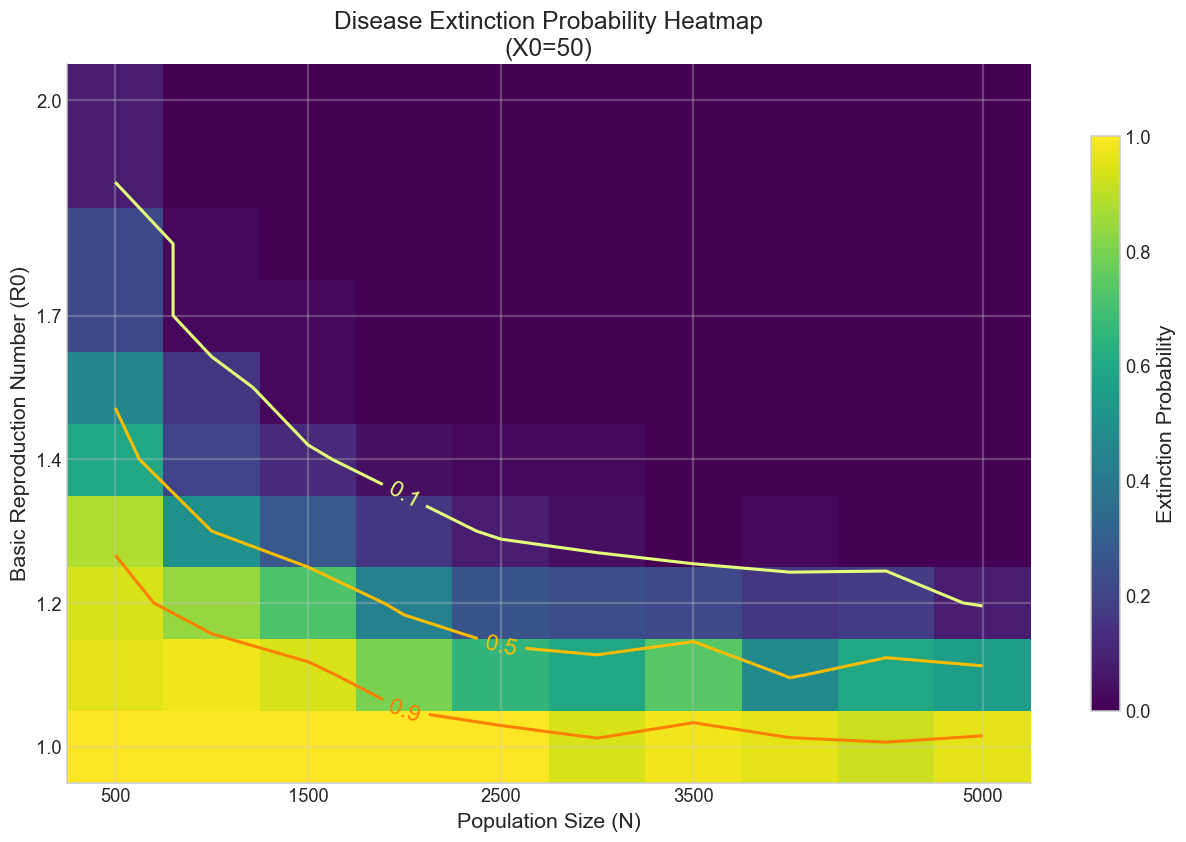

In [452]:
#FIXME: Re-run this to display X_0 on title correctly

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(
    extinction_heatmap, cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=1
)

# Set ticks and labels
n_ticks = 5
r0_tick_indices = np.linspace(0, len(R0_values) - 1, n_ticks, dtype=int)
n_tick_indices = np.linspace(0, len(N_values) - 1, n_ticks, dtype=int)

ax.set_xticks(n_tick_indices)
ax.set_xticklabels([f"{N_values[i]:.0f}" for i in n_tick_indices])
ax.set_yticks(r0_tick_indices)
ax.set_yticklabels([f"{R0_values[i]:.1f}" for i in r0_tick_indices])

# Labels and title
ax.set_xlabel("Population Size (N)")
ax.set_ylabel("Basic Reproduction Number (R0)")
ax.set_title(f"Disease Extinction Probability Heatmap\n($\X_0$={X0})")

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Extinction Probability")

# Add contour lines for specific extinction probabilities
contour_levels = [0.1, 0.5, 0.9]
contours = ax.contour(
    extinction_heatmap, levels=contour_levels, cmap="Wistia", linewidths=2
)
ax.clabel(contours, inline=True, fontsize=15, fmt="%.1f")

plt.tight_layout()
plt.show()

### Spatial Models

In [170]:
# Network Simulator Class

class NetworkSimulator:
    """
    Class to manage network generation, loading, and simulation experiments.
    """

    def __init__(self, seed: int = 42):
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.network_types: List[str] = [
            "erdos_renyi",
            "barabasi_albert",
            "watts_strogatz",
        ]
        self.networks: Dict[str, List[nx.Graph]] = {}
        self.experiment_results: Optional[pd.DataFrame] = None
        
        
    #####################################################################
    # Network Generation
    ######################################################################

    @staticmethod
    def _set_mean_degree(n_nodes: int, target_k: float) -> Tuple[float, int, int]:
        """
        Set similar mean degree for ER, BA, WS models.
        Returns:
            p: ER connection probability
            m: BA edges per new node
            k: WS initial neighbors
        """
        
        if n_nodes <= 1:
            p = 0.0
        else:
            p = target_k / (n_nodes - 1)
        p = float(np.clip(p, 0.0, 1.0))

        m = int(round(target_k / 2.0))
        m = max(1, min(m, n_nodes - 1))

        k = int(round(target_k))
        k = min(k, n_nodes - 1)
        if k % 2:
            k = k - 1 if k > 1 else 2
        k = max(2, min(k, n_nodes - 2))
        return p, m, k

    def add_network(self, name: str, G: nx.Graph):
        """Add a custom network to the simulator."""
        
        if name not in self.networks:
            self.networks[name] = []
            if name not in self.network_types:
                self.network_types.append(name)
        self.networks[name].append(G)

    def load_sociopatterns(
        self,
        path: str,
        threshold: float = 0.0,
        giant_component: bool = True,
        relabel_to_int: bool = True,
    ) -> nx.Graph:
        """
        Load sociopatterns transmission network from CSV.

        Parameters:
            path: Path to transmission_network.csv file
            threshold: Minimum edge weight to include
            giant_component: Keep only largest connected component
            relabel_to_int: Relabel nodes to integers 0..N-1

        Returns:
            Processed NetworkX graph
        """
        
        df = pd.read_csv(path, sep=";", header=None)

        labels_row = df.iloc[0, 1:].astype(int).tolist()
        labels_col = df.iloc[1:, 0].astype(int).tolist()
        if labels_row != labels_col:
            raise ValueError("Row/column labels mismatch in sociopatterns file.")

        A = df.iloc[1:, 1:].to_numpy(dtype=float)

        # Build undirected, unweighted graph
        G = nx.Graph()
        G.add_nodes_from(labels_row)
        n = A.shape[0]

        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] > threshold:
                    G.add_edge(labels_row[i], labels_row[j])

        if giant_component and G.number_of_nodes() > 0 and not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

        # Relabel to integers 0..N-1
        if relabel_to_int:
            nx.set_node_attributes(G, {old: {"orig_id": old} for old in G.nodes()})
            mapping = {old: i for i, old in enumerate(G.nodes())}
            G = nx.relabel_nodes(G, mapping, copy=True)

        self.add_network("sociopatterns", G)

        degs = [d for _, d in G.degree()]
        print(
            f"[Sociopatterns] N={G.number_of_nodes()}, L={G.number_of_edges()}, ⟨k⟩={np.mean(degs):.2f}"
        )
        return G

    def generate_networks(
        self,
        n_nodes: int = 100,
        n_instances: int = 5,
        target_k: float = 6.0,
        ws_p: float = 0.3,
    ) -> Dict[str, List[nx.Graph]]:
        """
        Generate ER, BA, and WS networks with similar mean degree.
        
        Params:
            n_nodes: Number of nodes
            n_instances: Number of instances per network type
            target_k: Target mean degree
            ws_p: WS rewiring probability
        Returns:
            Dictionary with network type as keys and list of generated graphs as values.
        """
        
        p, m, k = self._set_mean_degree(n_nodes, target_k)
        print(
            f"[Generate] N={n_nodes}, instances={n_instances}, target ⟨k⟩={target_k:.2f}"
        )
        print(f"  ER: p={p:.4f}   BA: m={m}   WS: k={k}, p_rewire={ws_p}")

        self.networks = {t: [] for t in self.network_types}
        for i in range(n_instances):
            base = self.seed + i
            self.networks["erdos_renyi"].append(
                nx.erdos_renyi_graph(n_nodes, p, seed=base)
            )
            self.networks["barabasi_albert"].append(
                nx.barabasi_albert_graph(n_nodes, m, seed=base)
            )
            self.networks["watts_strogatz"].append(
                nx.watts_strogatz_graph(n_nodes, k, ws_p, seed=base)
            )

        for t in self.network_types:
            means = [np.mean([d for _, d in G.degree()]) for G in self.networks[t]]
            print(
                f"  {t.replace('_',' ').title():>16}: realized ⟨k⟩ = {np.mean(means):.2f} ± {np.std(means):.2f}"
            )
        return self.networks
    
    #####################################################################
    # Metrics Computation
    #####################################################################

    def compute_network_stats(self, G: nx.Graph) -> Dict[str, float]:
        """
        Compute structural and epidemic-relevant network metrics.
        Returns:
            Dictionary with metric names as keys and computed values.
        """
        
        stats: Dict[str, float] = {}
        n = G.number_of_nodes()
        m = G.number_of_edges()
        stats["n_nodes"] = n
        stats["n_edges"] = m
        stats["density"] = nx.density(G)

        # Degree statistics
        degs = (
            np.fromiter((d for _, d in G.degree()), dtype=float, count=n)
            if n
            else np.array([])
        )
        if n > 0 and degs.size > 0:
            k1 = float(degs.mean())
            k2 = float((degs**2).mean())
            stats["avg_degree"] = k1
            stats["std_degree"] = float(degs.std())
            stats["min_degree"] = float(degs.min())
            stats["max_degree"] = float(degs.max())
            stats["second_moment_k2"] = k2
            stats["degree_heterogeneity"] = float(degs.var() / k1) if k1 > 0 else np.nan
            stats["tau_c_mean_over_second"] = (k1 / k2) if k2 > 0 else np.nan
        else:
            stats.update(
                {
                    "avg_degree": 0.0,
                    "std_degree": 0.0,
                    "min_degree": 0.0,
                    "max_degree": 0.0,
                    "second_moment_k2": 0.0,
                    "degree_heterogeneity": np.nan,
                    "tau_c_mean_over_second": np.nan,
                }
            )

        if n == 0:
            stats.update(
                {
                    "n_components": 0,
                    "lcc_frac": 0.0,
                    "avg_path_length": np.nan,
                    "diameter": np.nan,
                    "avg_clustering": np.nan,
                    "transitivity": np.nan,
                    "avg_betweenness": np.nan,
                }
            )
            return stats

        # Components and LCC
        if nx.is_connected(G):
            H = G
            stats["n_components"] = 1
            stats["lcc_frac"] = 1.0
        else:
            components = sorted(nx.connected_components(G), key=len, reverse=True)
            H = G.subgraph(components[0]).copy()
            stats["n_components"] = nx.number_connected_components(G)
            stats["lcc_frac"] = len(H) / n

        # Path metrics on LCC
        if H.number_of_nodes() > 1:
            stats["avg_path_length"] = nx.average_shortest_path_length(H)
            stats["diameter"] = nx.diameter(H)
        else:
            stats["avg_path_length"] = 0.0
            stats["diameter"] = 0.0

        # Clustering
        stats["avg_clustering"] = nx.average_clustering(G) if n > 0 else np.nan
        stats["transitivity"] = nx.transitivity(G) if n > 0 else np.nan

        # Betweenness (sampled)
        k_sample = min(100, n)
        bet = nx.betweenness_centrality(G, k=k_sample, seed=self.seed)
        stats["avg_betweenness"] = float(np.mean(list(bet.values()))) if bet else 0.0
        return stats
    

    def compute_epidemic_metrics(self, result: Dict) -> Dict[str, float]:
        """
        Compute epidemic metrics from simulation results.

        Returns:
            Dictionary with metric names as keys and computed values.
        """
        
        N = result["n_nodes"]
        trends = result["trends"][0]["trends"]["node_count"]
        I_curve = np.asarray(trends[1], dtype=float)
        R_curve = np.asarray(trends[2], dtype=float)

        attack_rate = float(R_curve[-1] / N) if N > 0 else np.nan

        nz = np.nonzero(I_curve)[0]
        epidemic_duration = int(nz[-1] + 1) if nz.size > 0 else 0

        # Early exponential growth rate
        t_peak = int(result["time_to_peak"])
        cutoff = max(3, int(0.3 * t_peak))
        early = I_curve[:cutoff]
        if early.size >= 3:
            logI = np.log(early + 1.0)
            x = np.arange(len(logI))
            slope, _ = np.polyfit(x, logI, 1)
            growth_rate = float(slope)
        else:
            growth_rate = np.nan

        return {
            "attack_rate": attack_rate,
            "epidemic_duration": epidemic_duration,
            "exponential_growth_rate": growth_rate,
        }

    def compute_all_metrics(self, G: nx.Graph, sim_result: Dict) -> Dict[str, float]:
        """
        Combine network and epidemic metrics
        Returns:
            Dictionary with all metrics
        """
        net = self.compute_network_stats(G)
        epi = self.compute_epidemic_metrics(sim_result)
        merged = dict(net)
        merged.update(
            {
                "beta": sim_result["beta"],
                "gamma": sim_result["gamma"],
                "R0_naive": (
                    (sim_result["beta"] / sim_result["gamma"])
                    if sim_result["gamma"] > 0
                    else np.inf
                ),
                "peak_infected": sim_result["peak_infected"],
                "time_to_peak": sim_result["time_to_peak"],
                "final_recovered": sim_result["final_recovered"],
                "peak_frac": sim_result["peak_frac"],
                "final_size_frac": sim_result["final_size_frac"],
            }
        )
        merged.update(epi)
        return merged

    #####################################################################
    # SIR Simulation
    #####################################################################

    def run_sir_simulation(
        self,
        G: nx.Graph,
        beta: float = 0.5,
        gamma: float = 0.1,
        fraction_infected: float = 0.05,
        iterations: int = 200,
        seed: Optional[int] = None,
    ) -> Dict[str, object]:
        
        """
        Run basic SIR simulation on network.
        Params:
            G: NetworkX graph
            beta: Transmission rate
            gamma: Recovery rate
            fraction_infected: Initial fraction infected
            iterations: Number of time steps
            seed: Random seed for reproducibility
        Returns:
            Dictionary with simulation results and parameters
        """
        
        if seed is not None:
            np.random.seed(seed)

        model = ep.SIRModel(G)
        config = mc.Configuration()
        config.add_model_parameter("beta", float(beta))
        config.add_model_parameter("gamma", float(gamma))
        config.add_model_parameter("fraction_infected", float(fraction_infected))
        model.set_initial_status(config)

        iters = model.iteration_bunch(iterations)
        trends = model.build_trends(iters)

        s2i = getattr(
            model, "available_statuses", {"Susceptible": 0, "Infected": 1, "Removed": 2}
        )
        I_idx = s2i["Infected"]
        R_idx = s2i["Removed"]

        node_count = trends[0]["trends"]["node_count"]
        infected = np.asarray(node_count[I_idx], dtype=float)
        removed = np.asarray(node_count[R_idx], dtype=float)

        peak_infected = float(infected.max())
        time_to_peak = int(infected.argmax())
        final_recovered = float(removed[-1])
        N = G.number_of_nodes()

        return {
            "trends": trends,
            "iterations": iters,
            "beta": beta,
            "gamma": gamma,
            "fraction_infected": fraction_infected,
            "n_nodes": N,
            "peak_infected": peak_infected,
            "time_to_peak": time_to_peak,
            "final_recovered": final_recovered,
            "peak_frac": peak_infected / N if N else np.nan,
            "final_size_frac": final_recovered / N if N else np.nan,
        }
        

    ###########################################################`
    # Seeding Startegies
    ###########################################################

    def run_sir_with_targeted_seeds(
        self,
        G: nx.Graph,
        beta: float,
        gamma: float,
        n_infected: int = 5,
        strategy: str = "random",
        iterations: int = 200,
        seed: Optional[int] = None,
    ) -> Dict[str, object]:
        """
        Run SIR simulation with targeted initial infection based on node properties.

        Parameters:
            G: Network graph
            beta: Transmission rate
            gamma: Recovery rate
            n_infected: Number of initial infected nodes
            strategy: 'random', 'high_betweenness', 'low_betweenness'
            iterations: Number of time steps
            seed: Random seed

        Returns:
            Dictionary with simulation results
        """
        if seed is not None:
            np.random.seed(seed)
            rng = np.random.default_rng(seed)
        else:
            rng = self.rng

        nodes = list(G.nodes())
        n_infected = min(n_infected, len(nodes))

        # Select initial infected nodes based on strategy
        if strategy == "random":
            infected_nodes = list(rng.choice(nodes, size=n_infected, replace=False))

        elif strategy == "high_betweenness":
            # Sample for efficiency
            k_sample = min(100, len(nodes))
            betweenness = nx.betweenness_centrality(G, k=k_sample, seed=self.seed)
            sorted_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
            infected_nodes = [node for node, bet in sorted_nodes[:n_infected]]

        elif strategy == "low_betweenness":
            k_sample = min(100, len(nodes))
            betweenness = nx.betweenness_centrality(G, k=k_sample, seed=self.seed)
            sorted_nodes = sorted(
                betweenness.items(), key=lambda x: x[1], reverse=False
            )
            infected_nodes = [node for node, bet in sorted_nodes[:n_infected]]

        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # Initialize and run model
        
        model = ep.SIRModel(G)
        config = mc.Configuration()
        config.add_model_parameter("beta", float(beta))
        config.add_model_parameter("gamma", float(gamma))
        config.add_model_initial_configuration("Infected", infected_nodes)
        model.set_initial_status(config)

        iters = model.iteration_bunch(iterations)
        trends = model.build_trends(iters)

        # Get metrics
        s2i = getattr(
            model, "available_statuses", {"Susceptible": 0, "Infected": 1, "Removed": 2}
        )
        I_idx = s2i["Infected"]
        R_idx = s2i["Removed"]

        node_count = trends[0]["trends"]["node_count"]
        infected = np.asarray(node_count[I_idx], dtype=float)
        removed = np.asarray(node_count[R_idx], dtype=float)

        peak_infected = float(infected.max())
        time_to_peak = int(infected.argmax())
        final_recovered = float(removed[-1])
        N = G.number_of_nodes()

        return {
            "trends": trends,
            "iterations": iters,
            "beta": beta,
            "gamma": gamma,
            "n_infected": n_infected,
            "strategy": strategy,
            "infected_nodes": infected_nodes,
            "n_nodes": N,
            "peak_infected": peak_infected,
            "time_to_peak": time_to_peak,
            "final_recovered": final_recovered,
            "peak_frac": peak_infected / N if N else np.nan,
            "final_size_frac": final_recovered / N if N else np.nan,
        }

    ###########################################################
    # Vaccination Methods
    ###########################################################

    def _ndlib_init_with_seeds(
        self,
        G: nx.Graph,
        beta: float,
        gamma: float,
        infected0: List[int],
        removed0: Optional[List[int]] = None,
    ):
        """
        Create NDlib SIR model with explicit initial states.
        """
        removed0 = removed0 or []

        model = ep.SIRModel(G)
        cfg = mc.Configuration()
        cfg.add_model_parameter("beta", float(beta))
        cfg.add_model_parameter("gamma", float(gamma))

        if infected0:
            cfg.add_model_initial_configuration("Infected", list(infected0))
        if removed0:
            cfg.add_model_initial_configuration("Removed", list(removed0))

        model.set_initial_status(cfg)
        return model

    def _test_node(self, true_status: int, acc: float, rng: np.random.Generator) -> int:
        """
        Simulate testing with given accuracy.
        Returns:
            0: Susceptible
            1: Infected
            2: Removed (always correctly identified)
        """
        true = 0 if true_status == 2 else true_status
        flip = rng.random() > acc
        return (1 - true) if flip else true

    def score_nodes(
        self,
        G: nx.Graph,
        obs_status: Dict[int, int],
        alpha: float = 1.0,
        beta_w: float = 0.25,
        gamma_w: float = 0.0,
    ) -> Dict[int, float]:
        """
        Risk score for vaccination prioritization.
        score(u) = alpha * (infected neighbors)
                 + beta_w * degree(u)
                 + gamma_w * (2-hop paths to infected)

        obs_status: {node: -1(unknown), 0(S), 1(I), 2(R)}
        """
        score: Dict[int, float] = {}
        I_obs = {u for u, st in obs_status.items() if st == 1}
        for u in G.nodes():
            if obs_status.get(u, -1) == 2:  # Already removed
                continue

            nI = sum(1 for v in G.neighbors(u) if obs_status.get(v, -1) == 1)
            k = G.degree(u)

            if gamma_w > 0.0 and I_obs: # was not used during our experiments
                                        # kept as an idea in case of low     improvemnt
                h2 = sum(
                    1
                    for v in G.neighbors(u)
                    for w in G.neighbors(v)
                    if w != u and obs_status.get(w, -1) == 1
                )
            else:
                h2 = 0

            score[u] = alpha * nI + beta_w * k + gamma_w * h2
        return score

    def experiment_vaccination_mixed(
        self,
        G: nx.Graph,
        beta: float,
        gamma: float,
        tests_per_step: int,
        vaccines_per_step: int,
        test_accuracy: float,
        iterations: int = 300,
        seed_inits: int = 5,
        alpha_w: float = 1.0,
        beta_w: float = 0.25,
        gamma_w: float = 0.0,
        seed: int = 42,
    ):
        """
        Custom vaccination strategy.

        Parameters:
            G: Network graph
            beta: Transmission rate
            gamma: Recovery rate
            tests_per_step: Number of tests per time step
            vaccines_per_step: Number of vaccines per time step
            test_accuracy: Probability of correct test result
            iterations: Max number of time steps
            seed_inits: Initial infected nodes
            alpha_w, beta_w, gamma_w: Weights for risk scoring
            seed: Random seed
        Returns:
            Dictionary with simulation results and parameters
        """
        rng = np.random.default_rng(seed)

        nodes = np.array(list(G.nodes()))
        infected0 = list(
            rng.choice(nodes, size=min(seed_inits, len(nodes)), replace=False)
        )

        # Initialize model
        model = self._ndlib_init_with_seeds(G, beta, gamma, infected0, [])

        obs_status: Dict[int, int] = {u: -1 for u in G.nodes()}  # -1=unknown
        memory_window = 5
        last_pos = {u: -(10**9) for u in G.nodes()}

        I_curve: List[int] = []
        R_curve: List[int] = []
        SIR_counts: List[Tuple[int, int, int]] = []
        peak_I, t_peak = 0.0, 0
        N = G.number_of_nodes()
        deg_dict = dict(G.degree())

        for t in range(iterations):
            true_status = model.status

            # Testing phase
            if t == 0:
                deg_sorted = sorted(G.nodes(), key=lambda u: deg_dict[u], reverse=True)
                to_test = deg_sorted[: min(tests_per_step, len(deg_sorted))]
            else:
                scores = self.score_nodes(
                    G, obs_status, alpha=alpha_w, beta_w=beta_w, gamma_w=gamma_w
                )
                candidates = [
                    (u, s) for u, s in scores.items() if obs_status.get(u, -1) == -1
                ]
                candidates.sort(key=lambda x: (x[1], deg_dict[x[0]]), reverse=True)
                to_test = [u for u, _ in candidates[: max(0, tests_per_step)]]

            for u in to_test:
                lab = self._test_node(true_status[u], test_accuracy, rng)
                obs_status[u] = lab
                if lab == 1:
                    last_pos[u] = t

            # Expire old positives
            for u in G.nodes():
                if obs_status[u] == 1 and (t - last_pos[u]) > memory_window:
                    obs_status[u] = -1

            # Vaccination phase
            vaccines_left = vaccines_per_step
            I_obs = {
                u
                for u in G.nodes()
                if (t - last_pos[u]) <= memory_window and rng.random() < test_accuracy
            }

            ring_candidates: Set[int] = set()
            if I_obs:
                for w in I_obs:
                    for v in G.neighbors(w):
                        if obs_status.get(v, -1) in (-1, 0):
                            ring_candidates.add(v)

            ring_sorted = sorted(
                ring_candidates, key=lambda u: deg_dict.get(u, 0), reverse=True
            )
            for v in ring_sorted:
                if vaccines_left == 0:
                    break
                if model.status[v] == 0:
                    model.status[v] = 2
                    obs_status[v] = 2
                    vaccines_left -= 1

            used = 0
            for v in ring_sorted:
                if used >= vaccines_per_step:
                    break
                if model.status[v] == 0:
                    model.status[v] = 2
                    obs_status[v] = 2
                    used += 1

            vaccines_left = vaccines_per_step - used
            if vaccines_left > 0:
                # fill with top-degree susceptibles globally
                global_deg = sorted(G.nodes(), key=lambda u: deg_dict[u], reverse=True)
                fillers = [
                    u
                    for u in global_deg
                    if model.status[u] == 0 and obs_status.get(u, -1) in (-1, 0)
                ]
                for v in fillers[:vaccines_left]:
                    model.status[v] = 2
                    obs_status[v] = 2

            # Advance epidemic
            _ = model.iteration()
            vals = np.array([model.status[u] for u in G.nodes()], dtype=int)
            S = int(np.sum(vals == 0))
            I = int(np.sum(vals == 1))
            R = int(np.sum(vals == 2))
            SIR_counts.append((S, I, R))
            I_curve.append(I)
            R_curve.append(R)

            if I > peak_I:
                peak_I, t_peak = I, t
            if I == 0:
                break

        return {
            "policy": "Custom Ring Vaccination",
            "beta": beta,
            "gamma": gamma,
            "tests_per_step": tests_per_step,
            "vaccines_per_step": vaccines_per_step,
            "test_accuracy": test_accuracy,
            "iterations": len(I_curve),
            "SIR_counts": np.array(SIR_counts, dtype=int),
            "peak_infected": float(peak_I),
            "time_to_peak": int(t_peak),
            "final_recovered": float(R_curve[-1]) if R_curve else 0.0,
            "peak_frac": (peak_I / N) if N else np.nan,
            "final_size_frac": (R_curve[-1] / N) if R_curve else 0.0,
            "n_nodes": N,
        }

    def experiment_vaccination_random(
        self,
        G: nx.Graph,
        beta: float,
        gamma: float,
        tests_per_step: int,
        vaccines_per_step: int,
        test_accuracy: float,
        iterations: int = 300,
        seed_inits: int = 5,
        seed: int = 5678,
    ):
        """
        Random vaccination baseline (no testing/targeting).
        Parameters:
            G: Network graph
            beta: Transmission rate
            gamma: Recovery rate
            tests_per_step: Number of tests per time step (not used)
            vaccines_per_step: Number of vaccines per time step
            test_accuracy: Probability of correct test result (not used)
            iterations: Max number of time steps
            seed_inits: Initial infected nodes
            seed: Random seed
        Returns:
            Dictionary with simulation results and parameters
        """
        rng = np.random.default_rng(seed)
        nodes = np.array(list(G.nodes()))
        infected0 = list(
            rng.choice(nodes, size=min(seed_inits, len(nodes)), replace=False)
        )
        model = self._ndlib_init_with_seeds(G, beta, gamma, infected0, [])

        I_curve: List[int] = []
        R_curve: List[int] = []
        SIR_counts: List[Tuple[int, int, int]] = []
        peak_I, t_peak = 0.0, 0
        N = G.number_of_nodes()

        for t in range(iterations):
            # Random vaccination
            eligible = [u for u in G.nodes() if model.status[u] != 2]
            rng.shuffle(eligible)
            for v in eligible[: max(0, vaccines_per_step)]:
                model.status[v] = 2

            _ = model.iteration()
            vals = np.array([model.status[u] for u in G.nodes()], dtype=int)
            S = int(np.sum(vals == 0))
            I = int(np.sum(vals == 1))
            R = int(np.sum(vals == 2))
            SIR_counts.append((S, I, R))
            I_curve.append(I)
            R_curve.append(R)

            if I > peak_I:
                peak_I, t_peak = I, t
            if I == 0:
                break

        return {
            "policy": "Random",
            "beta": beta,
            "gamma": gamma,
            "tests_per_step": tests_per_step,
            "vaccines_per_step": vaccines_per_step,
            "test_accuracy": test_accuracy,
            "iterations": len(I_curve),
            "SIR_counts": np.array(SIR_counts, dtype=int),
            "peak_infected": float(peak_I),
            "time_to_peak": int(t_peak),
            "final_recovered": float(R_curve[-1]) if R_curve else 0.0,
            "peak_frac": (peak_I / N) if N else np.nan,
            "final_size_frac": (R_curve[-1] / N) if R_curve else 0.0,
            "n_nodes": N,
        }

    def sweep_dynamic_vaccination(
        self,
        G: nx.Graph,
        beta: float,
        gamma: float,
        budgets=(1, 3, 5, 10),
        accs=(0.5, 0.75, 1.0),
        iterations: int = 300,
        reps: int = 30,
        seed0: int = 2025,
    ) -> pd.DataFrame:
        """
        Sweep over budgets and test accuracies for vaccination strategies.
        Returns:
            DataFrame with summary metrics for each configuration.
        """
        rows = []
        for b in budgets:
            v = b
            for acc in accs:
                for r in range(reps):
                    s = seed0 + 100 * r

                    mixed = self.experiment_vaccination_mixed(
                        G,
                        beta,
                        gamma,
                        tests_per_step=b,
                        vaccines_per_step=v,
                        test_accuracy=acc,
                        iterations=iterations,
                        seed_inits=5,
                        seed=s,
                    )
                    rnd = self.experiment_vaccination_random(
                        G,
                        beta,
                        gamma,
                        tests_per_step=b,
                        vaccines_per_step=v,
                        test_accuracy=acc,
                        iterations=iterations,
                        seed_inits=5,
                        seed=s + 1,
                    )

                    for res in (mixed, rnd):
                        rows.append(
                            {
                                "policy": res["policy"],
                                "tests_per_step": res["tests_per_step"],
                                "vaccines_per_step": res["vaccines_per_step"],
                                "test_accuracy": res["test_accuracy"],
                                "rep": r,
                                "peak_frac": res["peak_frac"],
                                "final_size_frac": res["final_size_frac"],
                                "time_to_peak": res["time_to_peak"],
                                "duration": res["iterations"],
                                "n_nodes": res["n_nodes"],
                                "beta": res["beta"],
                                "gamma": res["gamma"],
                                "R0": (beta / gamma) if gamma > 0 else np.inf,
                            }
                        )
        return pd.DataFrame(rows)

In [190]:
# Plotting Class
from scipy import stats

class Plotter:
    def __init__(self, sim, pretty_style=True):
        self.sim = sim
        if pretty_style:
            plt.rcParams.update(
                {
                    "figure.dpi": 110,
                    "axes.grid": True,
                    "grid.alpha": 0.3,
                    "axes.spines.top": False,
                    "axes.spines.right": False,
                }
            )

    def structure_overview(self):
        """Network structure comparison with summary table and distribution visualizations."""
        
        sim = self.sim
        if not sim.networks:
            raise RuntimeError("No networks stored")

        rows = []
        for nt in sim.network_types:
            for G in sim.networks[nt]:
                s = sim.compute_network_stats(G)
                s["network_type"] = nt
                rows.append(s)
        df = pd.DataFrame(rows)

        cols = [
            ("avg_betweenness", "⟨betweenness⟩"),
            ("std_degree", "std(k)"),
            ("avg_path_length", "APL(LCC)"),
            ("avg_clustering", "clustering"),
            ("tau_c_mean_over_second", "τc=⟨k⟩/⟨k²⟩"),
        ]

        agg = df.groupby("network_type")[[c for c, _ in cols]].agg(["mean", "std"])
        pretty = pd.DataFrame(index=agg.index)

        for c, label in cols:
            m = agg[(c, "mean")]
            sd = agg[(c, "std")]
            if c in ("std_degree", "avg_path_length"):
                fmt = lambda x: f"{x:.2f}"
            elif c in (
                "avg_betweenness",
                "avg_clustering",
                "tau_c_mean_over_second",
            ):
                fmt = lambda x: f"{x:.4f}"
            else:
                fmt = lambda x: f"{x:.3f}"
            pretty[label] = [f"{fmt(mi)}±{fmt(si)}" for mi, si in zip(m, sd)]

        pretty.index = [nt.replace("_", " ").title() for nt in pretty.index]
        print("\nNetwork Structure: Means ± SD across instances")
        print(pretty.to_string())

        metrics = [
            ("avg_betweenness", "Average Betweenness Centrality"),
            ("std_degree", "Degree Standard Deviation"),
            ("avg_path_length", "Average Path Length (LCC)"),
            ("avg_clustering", "Average Clustering Coefficient"),
        ]

        n_cols = 2
        n_rows = int(np.ceil(len(metrics) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
        axes = axes.flatten()

        palette = sns.color_palette("Set2", n_colors=len(sim.network_types))
        colors = {nt: palette[i] for i, nt in enumerate(sim.network_types)}

        for ax, (key, label) in zip(axes, metrics):
            for nt in sim.network_types:
                data = df[df["network_type"] == nt][key].values

                # KDE curve
                if len(data) > 1 and data.std() > 0:
                    kde = stats.gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 200)
                    ax.plot(
                        x_range,
                        kde(x_range),
                        color=colors[nt],
                        linewidth=2.5,
                        label=nt.replace("_", " ").title(),
                    )
                    ax.fill_between(x_range, kde(x_range), alpha=0.3, color=colors[nt])

            ax.set_xlabel(label)
            ax.set_ylabel("Density")
            ax.set_title(label, fontweight="bold")
            ax.legend(frameon=True, fancybox=True, shadow=True)
            ax.grid(True, alpha=0.3, axis="y")

        for j in range(len(metrics), len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Network Structure Distributions", fontweight="bold", fontsize=14)
        plt.tight_layout()
        plt.show()
        
       # Degree distrubutions (bars) 
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for ax, t in zip(axes, sim.network_types):
            degrees = []
            for G in sim.networks[t]:
                degrees.extend([d for _, d in G.degree()])
            ax.hist(degrees, bins=30, edgecolor="black", alpha=0.75, color=colors[t])
            ax.set_title(t.replace("_", " ").title(), fontweight="bold")
            ax.set_xlabel("Degree")
            ax.set_ylabel("Frequency")
            ax.grid(True, alpha=0.3)

        plt.suptitle("Degree Distributions", fontweight="bold", fontsize=14)
        plt.tight_layout()
        plt.show()

    def sir_comparison(
        self,
        beta=0.1,
        gamma=0.05,
        fraction_infected=[0.02],
        iterations=220,
        n_reps=1
    ):
        """
        Compare SIR dynamics across network types.

        Parameters:
            beta: Transmission rate
            gamma: Recovery rate
            fraction_infected: Initial infected fraction(s) value or list
            iterations: Number of time steps
            n_reps: Number of stochastic repetitions per configuration

        Returns:
            If return_results=True: DataFrame with columns:
                - network_type
                - beta, gamma, R0
                - fraction_infected
                - rep (repetition number)
                - peak_infected (count)
                - peak_fraction (fraction)
                - time_to_peak
                - final_recovered (count)
                - final_size_fraction
                - n_nodes
        """
        sim = self.sim

        if not isinstance(fraction_infected, list):
            fraction_infected = [fraction_infected]

        results = []

        for row_idx, frac_inf in enumerate(fraction_infected):
            for col_idx, net_type in enumerate(sim.network_types):
                G = sim.networks[net_type][0]

                for rep in range(n_reps):
                    res = sim.run_sir_simulation(
                        G,
                        beta=beta,
                        gamma=gamma,
                        fraction_infected=frac_inf,
                        iterations=iterations,
                        seed=sim.seed + rep,
                    )

                    trends = res["trends"][0]["trends"]["node_count"]

                    # Extract peak information
                    peak_i = max(trends[1])
                    peak_t = trends[1].index(peak_i)
                    N = G.number_of_nodes()

                    # Store results
                    results.append(
                        {
                            "network_type": net_type,
                            "beta": beta,
                            "gamma": gamma,
                            "R0": beta / gamma,
                            "fraction_infected": frac_inf,
                            "rep": rep,
                            "peak_infected": peak_i,
                            "peak_fraction": peak_i / N,
                            "time_to_peak": peak_t,
                            "final_recovered": trends[2][-1],
                            "final_size_fraction": trends[2][-1] / N,
                            "n_nodes": N,
                        }
                    )
        return pd.DataFrame(results)
    
    

    def network_gallery(self, instance: int = 0, degree_size: bool = True):
        """Visualize network structure with optimized layouts."""
        
        sim = self.sim
        types = ["erdos_renyi", "barabasi_albert", "watts_strogatz"]
        titles = {
            "erdos_renyi": "Erdős–Rényi (ER)",
            "barabasi_albert": "Barabási–Albert (BA)",
            "watts_strogatz": "Watts–Strogatz (WS)",
        }

        fig, axes = plt.subplots(1, len(types), figsize=(6 * len(types), 6))
        if len(types) == 1:
            axes = [axes]

        for ax, t in zip(axes, types):
            G = sim.networks[t][instance]

            if t == "erdos_renyi":
                pos = nx.spring_layout(G, seed=sim.seed, k=0.5, iterations=50)
            elif t == "barabasi_albert":
                pos = nx.kamada_kawai_layout(G)
            elif t == "watts_strogatz":
                pos = nx.circular_layout(G)
            else:
                pos = nx.spring_layout(G, seed=sim.seed)

            # Node sizing
            if degree_size:
                deg = np.array([d for _, d in G.degree()], dtype=float)
                if deg.size > 0 and deg.ptp() > 0:
                    normalized_deg = (deg - deg.min()) / deg.ptp()
                    s = 50 + 300 * normalized_deg
                else:
                    s = 150
            else:
                s = 150

            node_colors = [G.degree(n) for n in G.nodes()]

            ax.set_title(
                titles.get(t, t.replace("_", " ").title()),
                fontsize=14,
                fontweight="bold",
                pad=10,
            )

            nx.draw_networkx_nodes(
                G,
                pos,
                node_size=s,
                node_color=node_colors,
                cmap=plt.cm.viridis,
                vmin=min(node_colors),
                vmax=max(node_colors),
                edgecolors="black",
                linewidths=0.5,
                ax=ax,
            )
            nx.draw_networkx_edges(
                G, pos, alpha=0.5, width=0.5, edge_color="#333333", ax=ax
            )

            ax.axis("off")
            ax.set_aspect("equal")

        fig.suptitle("Network Type Gallery", fontsize=16, fontweight="bold", y=0.98)
        plt.tight_layout()
        plt.show()

    def betweenness_seeding_comparison(
        self,
        beta=0.1,
        gamma=0.05,
        fraction_infected_values=None,
        iterations=220,
        n_reps=20,
    ):
        """
        Compare high vs low betweenness seeding across network types.
        """
        sim = self.sim

        if fraction_infected_values is None:
            fraction_infected_values = np.linspace(0.01, 0.1, 10)

        palette = sns.color_palette("Set2", n_colors=len(sim.network_types))
        colors = {nt: palette[i] for i, nt in enumerate(sim.network_types)}

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        strategies = ["high_betweenness", "low_betweenness"]
        titles = ["High Betweenness Seeding", "Low Betweenness Seeding"]

        # Peak Infection Fraction
        for col, (strategy, title) in enumerate(zip(strategies, titles)):
            ax = axes[0, col]

            for net_type in sim.network_types:
                G = sim.networks[net_type][0]
                N = G.number_of_nodes()

                means = []
                stds = []

                for frac in fraction_infected_values:
                    n_infected = max(1, int(frac * N))

                    # Run multiple repetitions
                    peak_fracs = []
                    for rep in range(n_reps):
                        res = sim.run_sir_with_targeted_seeds(
                            G,
                            beta=beta,
                            gamma=gamma,
                            n_infected=n_infected,
                            strategy=strategy,
                            iterations=iterations,
                            seed=sim.seed + rep * 100,
                        )
                        peak_fracs.append(res["peak_frac"])

                    # Calculate mean and std
                    means.append(np.mean(peak_fracs))
                    stds.append(np.std(peak_fracs))

                means = np.array(means)
                stds = np.array(stds)

                ax.plot(
                    fraction_infected_values,
                    means,
                    color=colors[net_type],
                    linewidth=2.5,
                    marker="o",
                    markersize=8,
                    label=net_type.replace("_", " ").title(),
                )

                ax.fill_between(
                    fraction_infected_values,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    color=colors[net_type],
                )

            ax.set_xlabel("Initial Infection Fraction", fontweight="bold")
            ax.set_ylabel("Peak Infected Fraction", fontweight="bold")
            ax.set_title(title, fontweight="bold", fontsize=12)
            ax.legend(frameon=True, fancybox=True, shadow=True)
            ax.grid(True, alpha=0.3)

        # Time to Peak
        for col, (strategy, title) in enumerate(zip(strategies, titles)):
            ax = axes[1, col]

            for net_type in sim.network_types:
                G = sim.networks[net_type][0]
                N = G.number_of_nodes()

                means = []
                stds = []

                for frac in fraction_infected_values:
                    n_infected = max(1, int(frac * N))

                    times = []
                    for rep in range(n_reps):
                        res = sim.run_sir_with_targeted_seeds(
                            G,
                            beta=beta,
                            gamma=gamma,
                            n_infected=n_infected,
                            strategy=strategy,
                            iterations=iterations,
                            seed=sim.seed + rep * 100,
                        )
                        times.append(res["time_to_peak"])

                    means.append(np.mean(times))
                    stds.append(np.std(times))

                means = np.array(means)
                stds = np.array(stds)

                ax.plot(
                    fraction_infected_values,
                    means,
                    color=colors[net_type],
                    linewidth=2.5,
                    marker="o",
                    markersize=8,
                    label=net_type.replace("_", " ").title(),
                )

                ax.fill_between(
                    fraction_infected_values,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    color=colors[net_type],
                )

            ax.set_xlabel("Initial Infection Fraction", fontweight="bold")
            ax.set_ylabel("Time to Peak", fontweight="bold")
            ax.set_title(title, fontweight="bold", fontsize=12)
            ax.legend(frameon=True, fancybox=True, shadow=True)
            ax.grid(True, alpha=0.3)

        fig.suptitle(
            f"Betweenness Seeding Strategy (β={beta}, γ={gamma}, R₀={beta/gamma:.2f}, n={n_reps} reps)",
            fontweight="bold",
            fontsize=14,
        )
        plt.show()

### Network Structure Analysis

[Generate] N=50, instances=5, target ⟨k⟩=4.00
  ER: p=0.0816   BA: m=2   WS: k=4, p_rewire=0.15
       Erdos Renyi: realized ⟨k⟩ = 4.14 ± 0.39
   Barabasi Albert: realized ⟨k⟩ = 3.84 ± 0.00
    Watts Strogatz: realized ⟨k⟩ = 4.00 ± 0.00


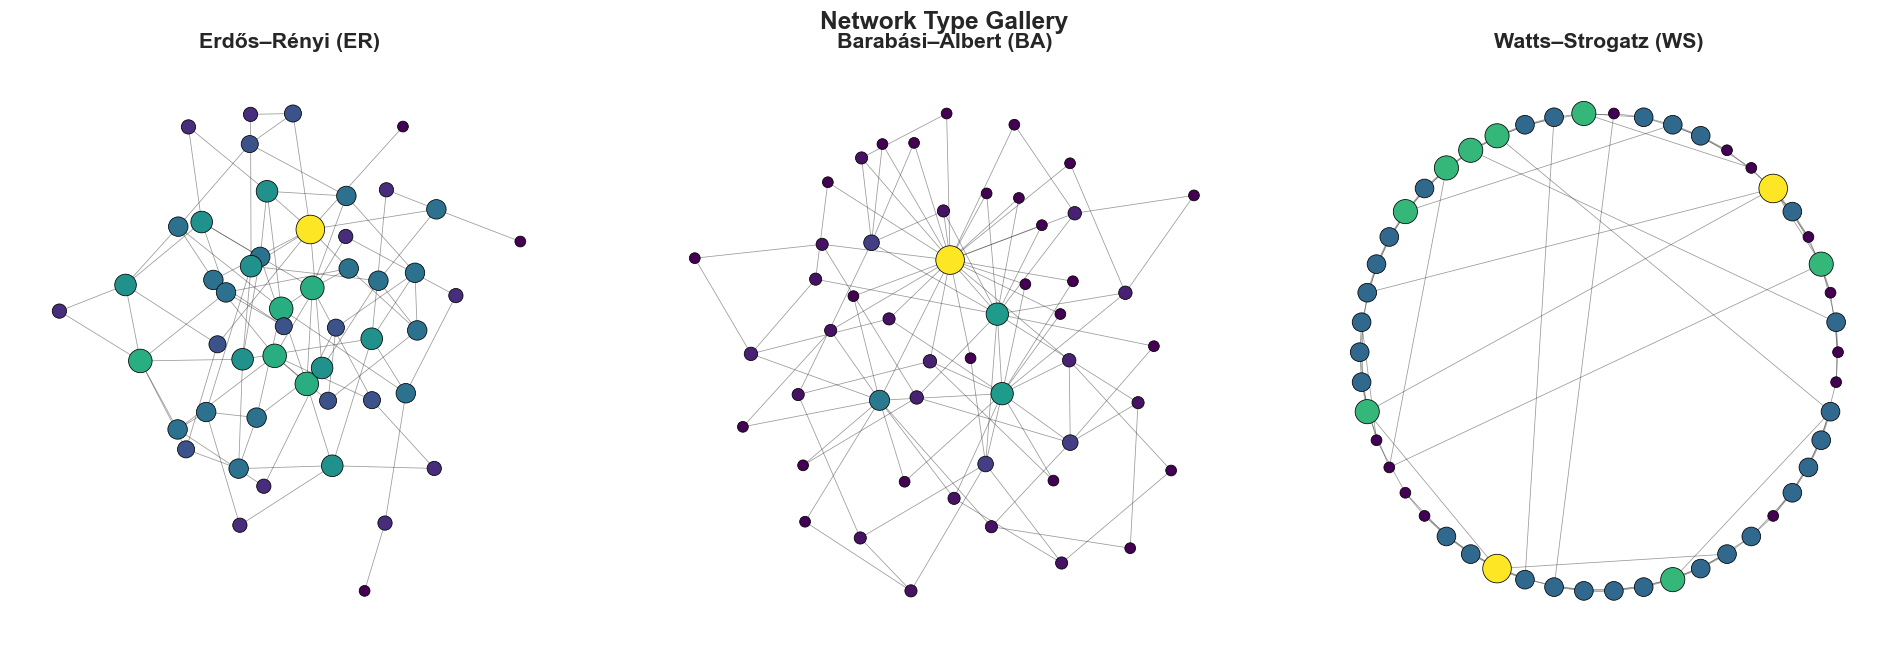

In [138]:
# Small Network Visualization
# Note: Use 50 nodes for illustration purposes

sim_small = NetworkSimulator(seed=42)
sim_small.generate_networks(n_nodes=50, n_instances=5, target_k=4.0, ws_p=0.15)
plot_small = Plotter(sim_small, pretty_style=True)
plot_small.network_gallery(instance=0, degree_size=True)

[Generate] N=1000, instances=20, target ⟨k⟩=4.00
  ER: p=0.0040   BA: m=2   WS: k=4, p_rewire=0.15
       Erdos Renyi: realized ⟨k⟩ = 4.00 ± 0.08
   Barabasi Albert: realized ⟨k⟩ = 3.99 ± 0.00
    Watts Strogatz: realized ⟨k⟩ = 4.00 ± 0.00

Network Structure: Means ± SD across instances
                 ⟨betweenness⟩     std(k)   APL(LCC)     clustering    τc=⟨k⟩/⟨k²⟩
Barabasi Albert  0.0031±0.0001  5.24±0.36  4.08±0.06  0.0263±0.0060  0.0924±0.0075
Erdos Renyi      0.0040±0.0001  2.00±0.04  5.10±0.07  0.0037±0.0014  0.2002±0.0036
Watts Strogatz   0.0067±0.0002  0.73±0.02  7.67±0.15  0.3212±0.0095  0.2419±0.0005


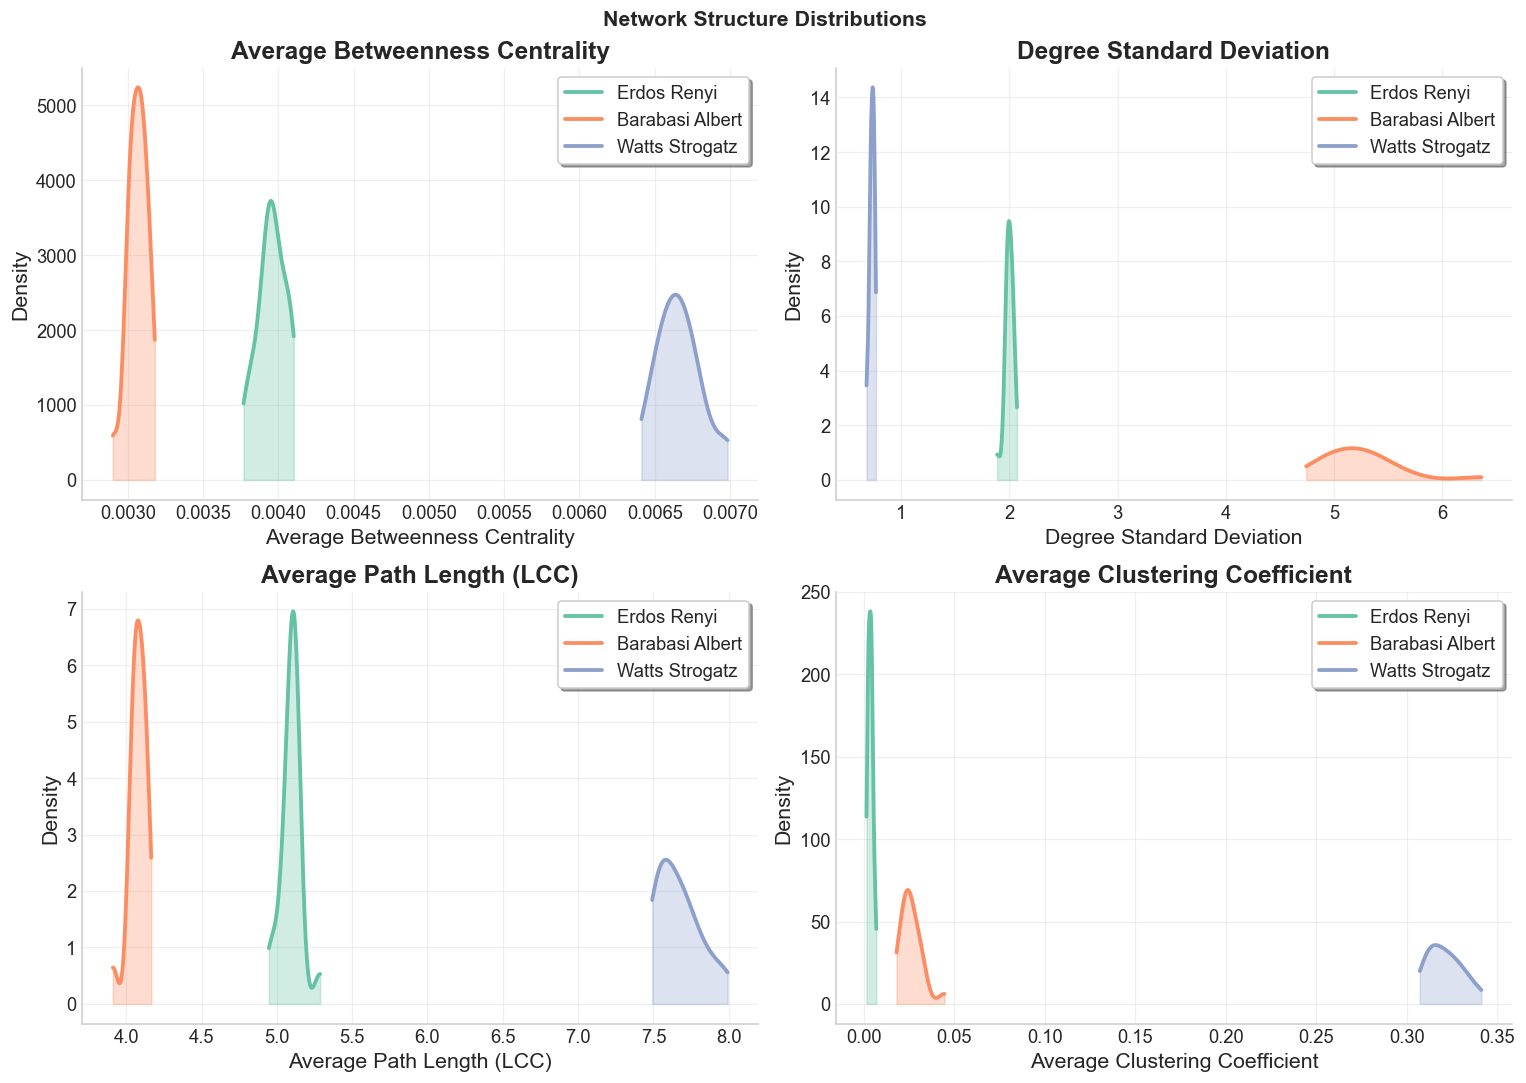

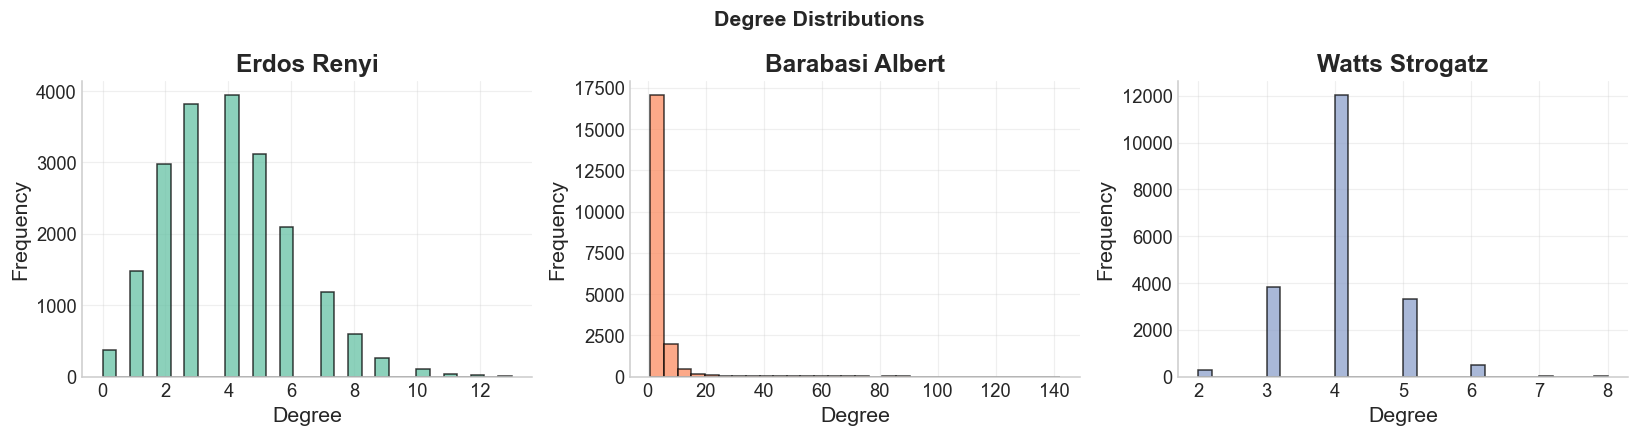

In [191]:
# Network Structure Analysis

sim = NetworkSimulator(seed=42)
sim.generate_networks(n_nodes=1000, n_instances=20, target_k=4.0, ws_p=0.15)

plot = Plotter(sim, pretty_style=True)
plot.structure_overview()

In [143]:
# Get SIR simulation results
fractions = np.linspace(0.01, 0.15, 15)
results = plot.sir_comparison(
    beta=0.1,
    gamma=0.05,
    fraction_infected=fractions.tolist(),
    iterations=220,
    n_reps=20,
)

In [146]:
summary = (
    results.groupby(["network_type", "fraction_infected"])
    .agg({"peak_fraction": ["mean", "std"], "time_to_peak": ["mean", "std"]})
    .reset_index()
)

# Flatten column names
summary.columns = [
    "network_type",
    "fraction_infected",
    "peak_mean",
    "peak_std",
    "time_mean",
    "time_std",
]

summary.head().round(4)


,network_type,fraction_infected,peak_mean,peak_std,time_mean,time_std
0,barabasi_albert,0.01,0.5254,0.0208,19.45,2.1145
1,barabasi_albert,0.02,0.5245,0.0225,18.25,1.5174
2,barabasi_albert,0.03,0.5296,0.0253,16.15,1.6311
3,barabasi_albert,0.04,0.5364,0.0241,15.60,1.5355
4,barabasi_albert,0.05,0.5421,0.0226,14.85,1.5313


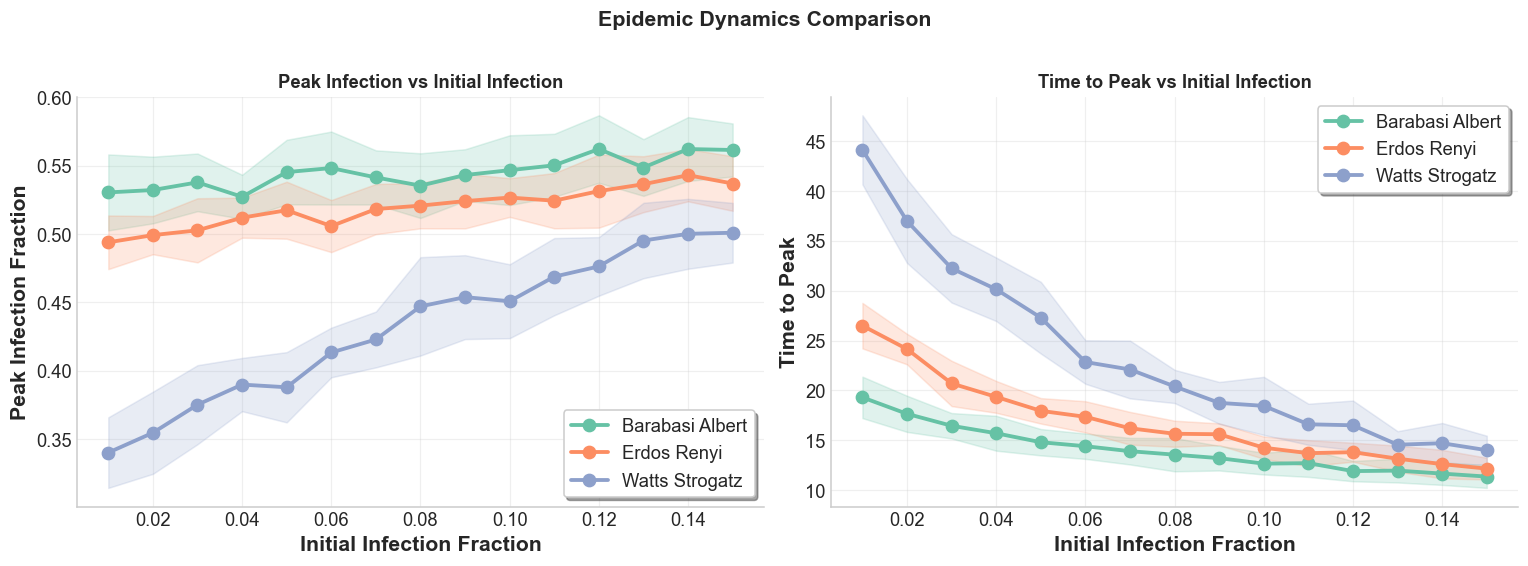

In [34]:
"""
Plots:
    1. Peak Infection vs. Initial Infection Fraction 
    2. Time to Peak vs. Initial Infection Fraction
"""


palette = sns.color_palette("Set2", n_colors=len(results["network_type"].unique()))
colors = {
    nt: palette[i] for i, nt in enumerate(sorted(results["network_type"].unique()))
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Peak infection vs initial infection
ax = axes[0]
for net_type in sorted(results["network_type"].unique()):
    data = summary[summary["network_type"] == net_type]
    color = colors[net_type]

    # Plot line
    ax.plot(
        data["fraction_infected"],
        data["peak_mean"],
        color=color,
        linewidth=2.5,
        marker="o",
        markersize=8,
        label=net_type.replace("_", " ").title(),
    )

    ax.fill_between(
        data["fraction_infected"],
        data["peak_mean"] - data["peak_std"],
        data["peak_mean"] + data["peak_std"],
        alpha=0.2,
        color=color,
    )

ax.set_xlabel("Initial Infection Fraction", fontweight="bold")
ax.set_ylabel("Peak Infection Fraction", fontweight="bold")
ax.set_title("Peak Infection vs Initial Infection", fontweight="bold", fontsize=12)
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)

# Time to peak vs initial infection
ax = axes[1]
for net_type in sorted(results["network_type"].unique()):
    data = summary[summary["network_type"] == net_type]
    color = colors[net_type]

    # Plot line
    ax.plot(
        data["fraction_infected"],
        data["time_mean"],
        color=color,
        linewidth=2.5,
        marker="o",
        markersize=8,
        label=net_type.replace("_", " ").title(),
    )

    # Add shaded error region
    ax.fill_between(
        data["fraction_infected"],
        data["time_mean"] - data["time_std"],
        data["time_mean"] + data["time_std"],
        alpha=0.2,
        color=color,
    )

ax.set_xlabel("Initial Infection Fraction", fontweight="bold")
ax.set_ylabel("Time to Peak", fontweight="bold")
ax.set_title("Time to Peak vs Initial Infection", fontweight="bold", fontsize=12)
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)

fig.suptitle("Epidemic Dynamics Comparison", fontweight="bold", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()

### Seeding Strategies (High and Low Degree)

***Note***: Complementary Experiment to the initial infection fraction variation. Here we intially infect nodes with the highes/lowest betweeness to observe network epidemic spread in terms of peak infected fraction and time to peak (per network type).

/var/folders/fm/9tf79c_d1691c4jwk2qqr42m0000gn/T/ipykernel_47994/2774151466.py:435: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()


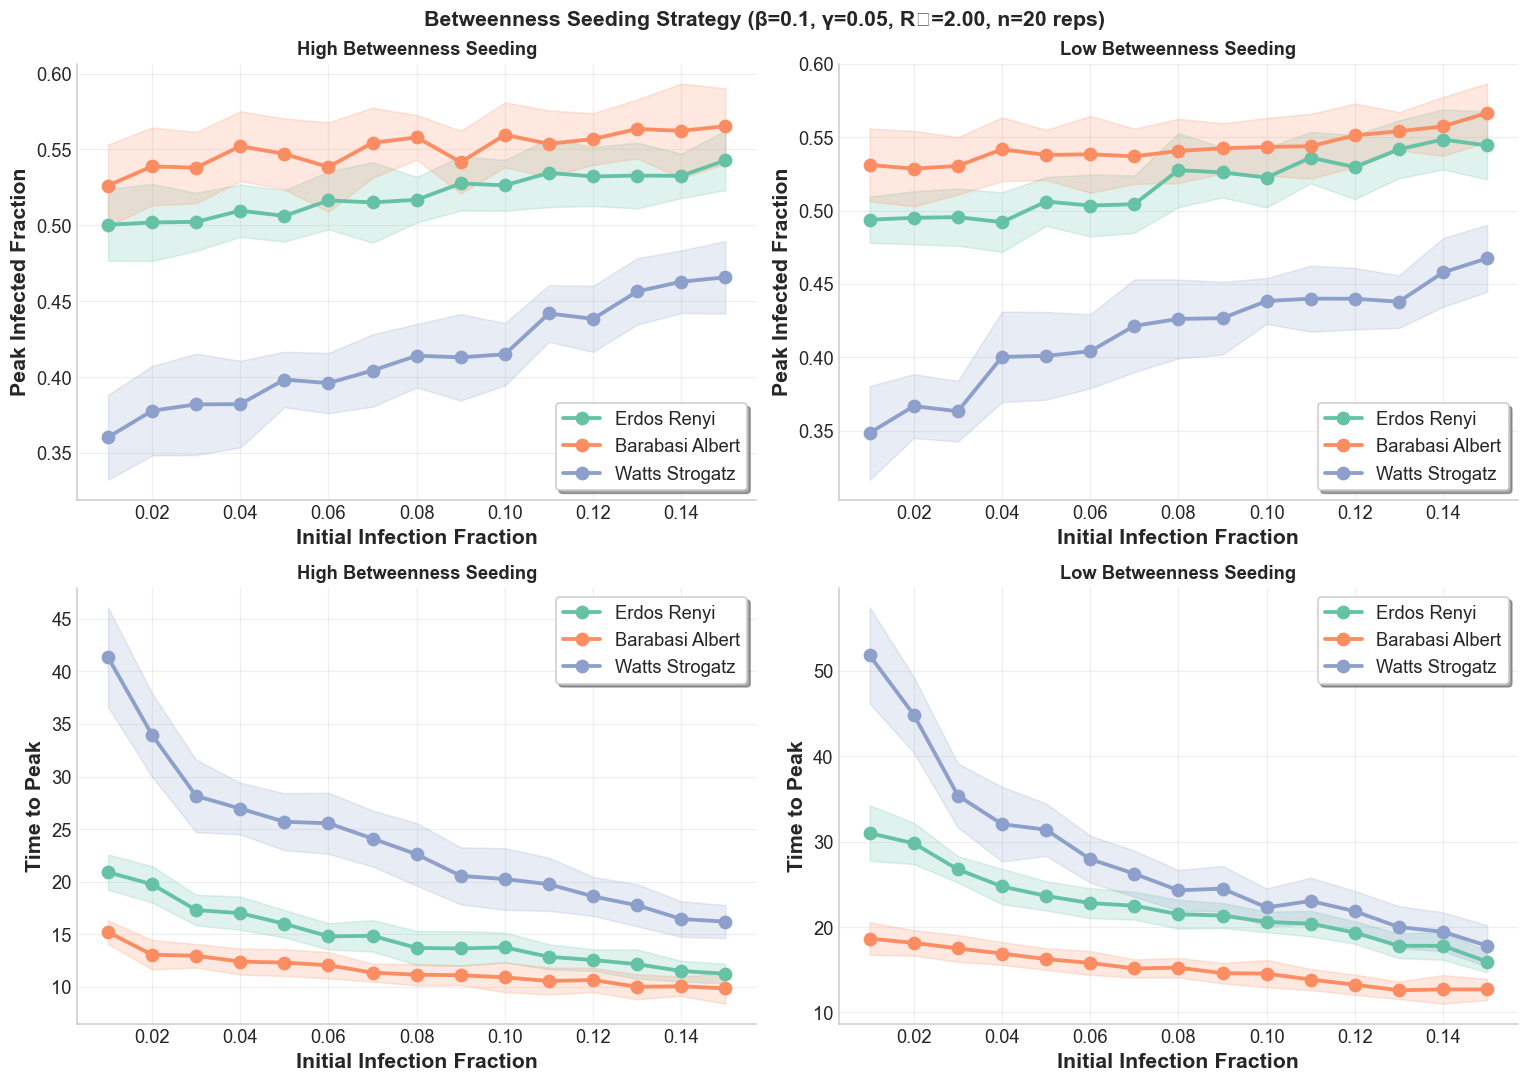

In [116]:
plot.betweenness_seeding_comparison(
    beta=0.1, gamma=0.05, fraction_infected_values=np.linspace(0.01, 0.15, 15)
)

### Sociopatterns Dataset

Loading the sociopatterns dataset and visualizing the network.

In [180]:
# Load real-world contact network
sim_sp = NetworkSimulator(seed=42)
Gsp = sim_sp.load_sociopatterns(
    "data/transmission_network.csv",
    threshold=0.0,
    giant_component=True,
    relabel_to_int=True,
)

[Sociopatterns] N=354, L=1263, ⟨k⟩=7.14


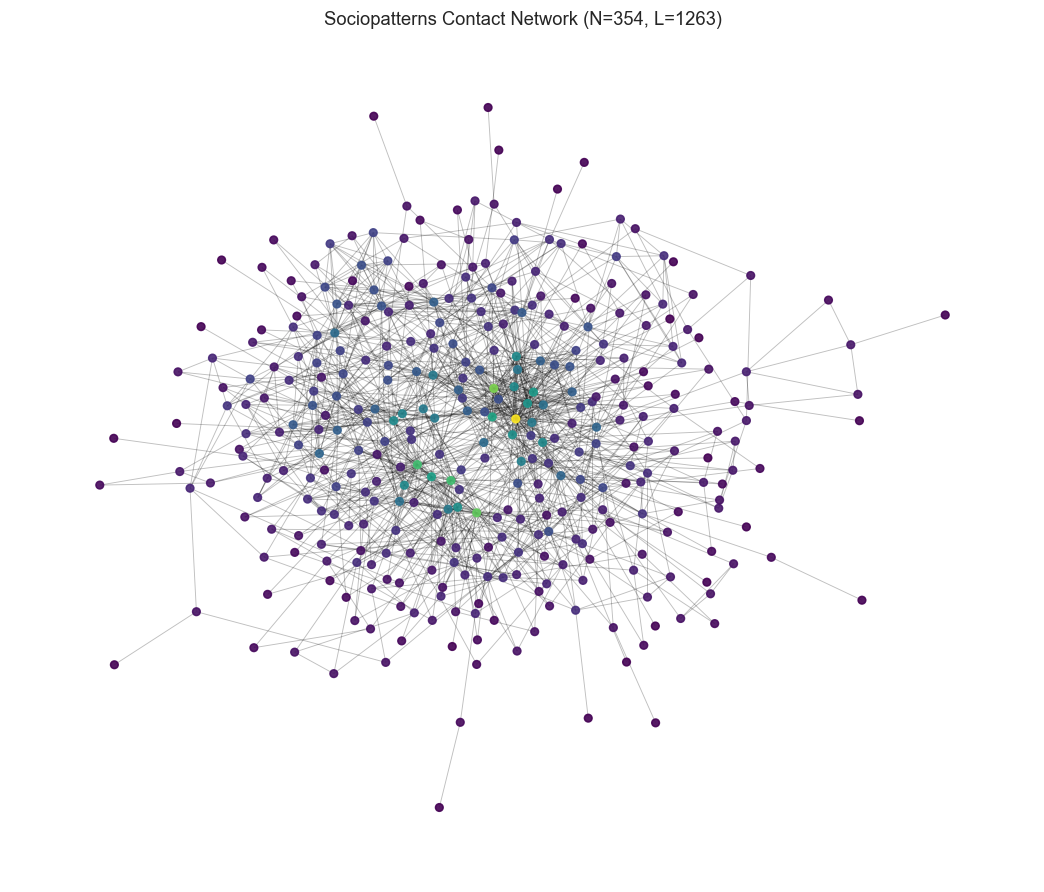

In [181]:
# Visualize network

plt.figure(figsize=(12, 10))
pos = nx.kamada_kawai_layout(Gsp)
deg = [d for _, d in Gsp.degree()]
nx.draw_networkx_nodes(
    Gsp, pos, node_color=deg, cmap="viridis", node_size=25, alpha=0.9
)
nx.draw_networkx_edges(Gsp, pos, alpha=0.25, width=0.6)
plt.title(
    f"Sociopatterns Contact Network (N={Gsp.number_of_nodes()}, "
    f"L={Gsp.number_of_edges()})",
    fontsize=12,
)
plt.axis("off")
plt.show()

In [182]:
# Get network statistics

stats = sim_sp.compute_network_stats(Gsp)
for k in [
    "n_nodes",
    "n_edges",
    "avg_degree",
    "std_degree",
    "density",
    "avg_clustering",
    "transitivity",
    "avg_path_length",
    "diameter",
    "second_moment_k2",
    "tau_c_mean_over_second",
    "degree_heterogeneity",
]:
    print(f"{k:25s} : {stats.get(k)}")

n_nodes                   : 354
n_edges                   : 1263
avg_degree                : 7.135593220338983
std_degree                : 6.446978779440251
density                   : 0.020214145100110433
avg_clustering            : 0.3127075569221226
transitivity              : 0.22441414007679067
avg_path_length           : 3.3638065972055506
diameter                  : 9
second_moment_k2          : 92.48022598870057
tau_c_mean_over_second    : 0.07715804264157859
degree_heterogeneity      : 5.82481849779245


### Vacciantion Strategy Metrics and Evaluation

In [183]:
# Running dynamic vaccination sweep across budgets and testing accuracies
# Note: R0 fixed at 1.2 (beta=0.06, gamma=0.05) for better visualization

df_vax = sim_sp.sweep_dynamic_vaccination(
    Gsp,
    beta=0.06,
    gamma=0.05,
    budgets=(1, 3, 5, 10),
    accs=(0.5, 0.75, 1.0),
    iterations=300,
    reps=40,
    seed0=2025,
)

In [184]:
# Fetch vaccination statistics

comparison_df = (
    df_vax.groupby(["policy", "tests_per_step", "test_accuracy"])
    .agg({"peak_frac": "mean", "final_size_frac": "mean"})
    .reset_index()
)

# Pivot to compare policies side by side
pivot_peak = comparison_df.pivot_table(
    values="peak_frac", index=["tests_per_step", "test_accuracy"], columns="policy"
)

pivot_peak["absolute_improvement"] = pivot_peak["Random"] - pivot_peak["Custom Ring Vaccination"]
pivot_peak["relative_improvement_%"] = (
    pivot_peak["absolute_improvement"] / pivot_peak["Random"] * 100
)
print("\nPeak Infection: Custom vs Random")
print(pivot_peak.head(5).round(4))


Peak Infection: Custom vs Random
policy                        Custom Ring Vaccination  Random  \
tests_per_step test_accuracy                                    
1              0.50                            0.3625  0.4754   
               0.75                            0.3538  0.4821   
               1.00                            0.3714  0.4734   
3              0.50                            0.1439  0.4004   
               0.75                            0.1401  0.4005   

policy                        absolute_improvement  relative_improvement_%  
tests_per_step test_accuracy                                                
1              0.50                         0.1129                 23.7522  
               0.75                         0.1282                 26.6042  
               1.00                         0.1020                 21.5543  
3              0.50                         0.2566                 64.0741  
               0.75                         0.26

In [167]:
# Get best relative improvement from custom policy

best_improvements = pivot_peak.nlargest(5, "relative_improvement_%")
print("Best Metric Improvements for Custom Vaccine\n")
print(best_improvements)

print(
    f"\nOverall average improvement: {pivot_peak['relative_improvement_%'].mean():.2f}%"
)
print(
    f"Best case improvement: {pivot_peak['relative_improvement_%'].max():.2f}% at budget={pivot_peak['relative_improvement_%'].idxmax()[0]}, accuracy={pivot_peak['relative_improvement_%'].idxmax()[1]}"
)
print(f"Worst case improvement: {pivot_peak['relative_improvement_%'].min():.2f}%")

Best Metric Improvements for Custom Vaccine

policy                        Custom Ring Vaccination    Random  \
tests_per_step test_accuracy                                      
10             1.00                          0.030791  0.159816   
               0.75                          0.038771  0.181780   
5              1.00                          0.074011  0.326271   
               0.75                          0.074788  0.317302   
10             0.50                          0.046328  0.175212   

policy                        absolute_improvement  relative_improvement_%  
tests_per_step test_accuracy                                                
10             1.00                       0.129025               80.733540  
               0.75                       0.143008               78.671329  
5              1.00                       0.252260               77.316017  
               0.75                       0.242514               76.430002  
10             0.50    

In [185]:
def plot_peak_vs_budget(df_sweep):
    
    """Compare peak infection vs budget across policies and accuracies."""
    
    g = (df_sweep.groupby(["policy", "test_accuracy", "tests_per_step"])["peak_frac"]
         .agg(["mean", "std", "count"]).reset_index())
    g["sem"] = g["std"] / np.sqrt(g["count"].clip(lower=1))
    
    acc_levels = sorted(g["test_accuracy"].unique())
    rpa_colors = {0.5: '#ef4444', 0.75: '#f59e0b', 1.0: '#10b981'}
    random_colors = {0.5: '#7c2d12', 0.75: '#831843', 1.0: '#4c1d95'}
    
    fig, ax = plt.subplots(figsize=(9, 6))
    
    for pol in sorted(g["policy"].unique(), reverse=True):
        colors = rpa_colors if pol == "Custom Ring Vaccination" else random_colors
        linestyle = "-" if pol == "Custom Ring Vaccination" else "--"
        
        for acc in acc_levels:
            sub = g[(g["policy"] == pol) & (g["test_accuracy"] == acc)]
            color = colors.get(acc, '#666666')
            ax.errorbar(sub["tests_per_step"], sub["mean"], yerr=1.96 * sub["sem"],
                       marker="o", markersize=7, capsize=4, capthick=1.5,
                       linewidth=2.5, linestyle=linestyle, color=color,
                       label=f"{pol} (acc={acc})", alpha=0.85)
    
    ax.set_xlabel("Tests/Vaccines per Step (Budget)", fontsize=12)
    ax.set_ylabel("Peak Infected Fraction (I/N)", fontsize=12)
    ax.set_title("Epidemic Peak vs Resource Budget\n"
                 "Comparing Custom and Random Vaccination Strategies",
                 fontsize=13, fontweight='bold', pad=15)
    ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)
    ax.legend(title="Policy & Test Accuracy", ncol=2, framealpha=0.95,
             fontsize=9, title_fontsize=10, loc='best')
    ax.set_xticks(sorted(g["tests_per_step"].unique()))
    plt.tight_layout()
    plt.show()

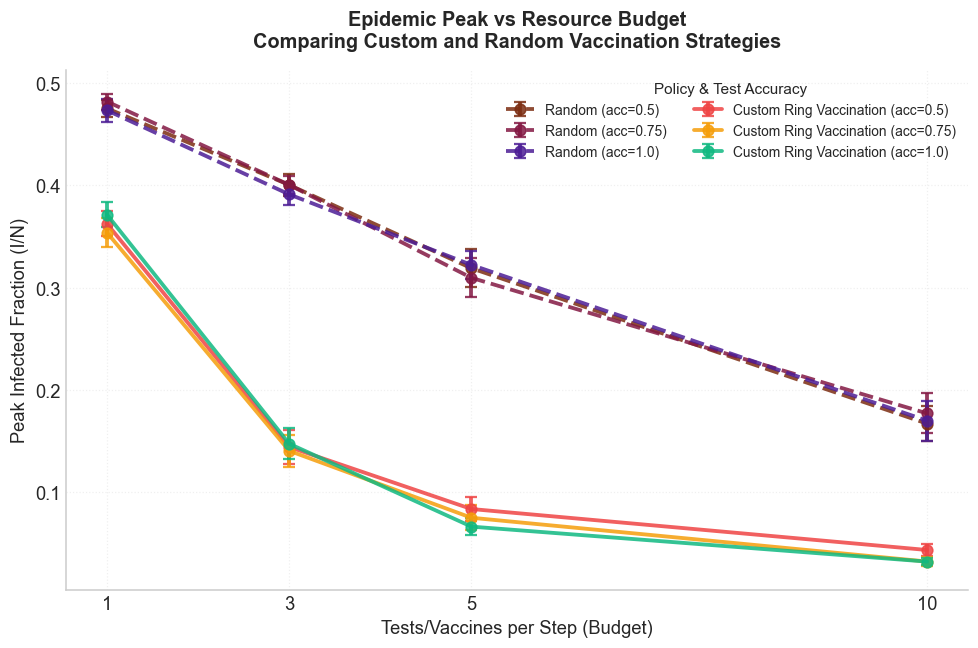

In [186]:
"""
Visualizing peak infection vs budget across policies and accuracies.
"""
plot_peak_vs_budget(df_vax)